### mape_choose_func

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import datetime
from sklearn.preprocessing import MinMaxScaler

In [4]:
def mape_func(data, target_date):
    group_data = data.loc[:'2010-10-31'].groupby(by='date')
    target_date = data.loc[target_date].index[1]                 #用于mape的时间
    aim_date = target_date + datetime.timedelta(days=1)          #需要预测的时间
    x_pred = data.loc[target_date, 'load'].values.flatten()
    def mapes(x_true,x_pred =x_pred):
        y = x_true['load'].values.flatten()
        x = x_pred
        mape = np.mean(np.abs(x - y)/x)*100
        return mape
       
    mape_data = group_data.apply(mapes)
    #train_index = mape_data[mape_data<10].index
    train_index = mape_data.sort_values()[1:61].index.sort_values()  #无敌
    #train_index = train_index[train_index != target_date]        #让预测数据不会进入模型
    vaild_index = train_index + datetime.timedelta(days=1)
    return train_index,vaild_index


### reshape_data_for_train_func

In [5]:
def reshape_data(index_T, index_V, data):
    sc_hour = MinMaxScaler()
    
    data['hour'] = sc_hour.fit_transform(data['hour'].values.reshape(-1,1))
    sc_temp = MinMaxScaler()
    data['temp'] = sc_temp.fit_transform(data['temp'].values.reshape(-1,1))
    sc_load = MinMaxScaler()
    data['load'] = sc_load.fit_transform(data['load'].values.reshape(-1,1))
    length = int(np.floor(index_T.shape[0]*0.7))
    print(length,'-------------------------------')
    X_train = data.loc[index_T].iloc[:length*48].values.reshape(-1,48,4)      
    y_train = data.loc[index_V].iloc[:length*48, 2].values.reshape(-1,48)    
    X_test = data.loc[index_T].iloc[length*48:].values.reshape(-1,48,4)
    y_test = data.loc[index_V].iloc[length*48:, 2].values.reshape(-1,48)
    
    #X_train, X_test, y_train, y_test = train_test_split(data.loc[index_T], data.loc[index_V, 'load'], test_size=0.3)
    return [X_train, X_test, y_train, y_test,sc_hour, sc_temp, sc_load]


### Lstm_Cnn_model

In [6]:
def modle_set():
    #建立LSTM模型 训练
    inputs=tf.keras.layers.Input(shape=(48, 4))
    model=tf.keras.layers.Conv1D(filters = 48, kernel_size = 1, activation = 'sigmoid')(inputs)#卷积层
    model=tf.keras.layers.Conv1D(filters = 48, kernel_size = 1, activation = 'sigmoid')(model)#卷积层
    #model=tf.keras.layers.Conv1D(filters = 48, kernel_size = 1, activation = 'sigmoid')(model)
    #model=tf.keras.layers.MaxPooling1D(pool_size = 48)(model)#池化层
    #model=tf.keras.layers.Dropout(0.03)(model)#droupout层
    #model=tf.keras.layers.GRU(48, activation='tanh', return_sequences=True)(model)
    #model=tf.keras.layers.Dropout(0.03)(model)
    model=tf.keras.layers.LSTM(48, activation='tanh', return_sequences=True)(model)
    #model=tf.keras.layers.LSTM(48, activation='tanh', return_sequences=True)(model)
    #model=tf.keras.layers.Dropout(0.03)(model)
    model=tf.keras.layers.LSTM(48, activation='tanh')(model)
    #model=tf.keras.layers.LSTM(48, activation='tanh')(model)
    outputs = tf.keras.layers.Dense(48)(model)
    model = tf.keras.models.Model(inputs=inputs, outputs=outputs)
    model.compile(loss='mse',optimizer='adam',metrics=['accuracy'])
    model.summary()#展示模型结构
    return model

# main

In [7]:
def mainSet(data, target_date, aim_data):   
    data_real = data.copy()                                                                           #未归一化的datarale
    
    
    train_index,vaild_index = mape_func(data, target_date)
    a = reshape_data(train_index, vaild_index, data)                                                  #会将data     normolization
    
    model = modle_set()
    model.fit(a[0], a[2], epochs = 30, batch_size = 16,shuffle=True,validation_data=(a[1], a[3]))   #训练模型--专属

    for_pred = data.loc[target_date].values.reshape(1,48,4)                                            #用前一天

    pred_data = model.predict(for_pred)                                                                #预测后一天
    pred_data_true = a[-1].inverse_transform(pred_data.reshape(-1,1)).flatten()
    true_value = data_real.loc[aim_data,'load'].values.flatten()                                       #后一天的真实值 
    
    #print(target_date, 'to predict', aim_data)
    
    plt.plot(pred_data_true, 'b')
    plt.plot(true_value,'r')
    plt.show()
    
    #print('pred')
    #print(pred_data_true)
    #print('true')
    #print(true_value)
    mapes = np.mean(np.abs(true_value - pred_data_true)/true_value)*100
    #print('mape:', mapes)
    return pred_data_true, true_value, mapes

# 实验开始

In [3]:
data = pd.read_csv('datas.csv', index_col=['date'], parse_dates=['date'])
data.loc[:'2010-11-30']

hour   temp        load  weekday
date                                        
2006-01-04   0.0  19.50  7526.44167        0
2006-01-04   0.5  19.35  7340.25500        0
2006-01-04   1.0  19.20  7113.48333        0
2006-01-04   1.5  19.10  6772.77000        0
2006-01-04   2.0  19.00  6490.73167        0
...          ...    ...         ...      ...
2010-11-30  21.5  19.15  8264.15000        0
2010-11-30  22.0  19.20  8009.86000        0
2010-11-30  22.5  19.20  8072.83000        0
2010-11-30  23.0  19.20  7969.69000        0
2010-11-30  23.5  19.10  7781.70000        0

[86016 rows x 4 columns]

In [4]:
data = data.loc[:'2010-11-30']
img = data.load.values
img

array([7526.44167, 7340.255  , 7113.48333, ..., 8072.83   , 7969.69   ,
       7781.7    ])

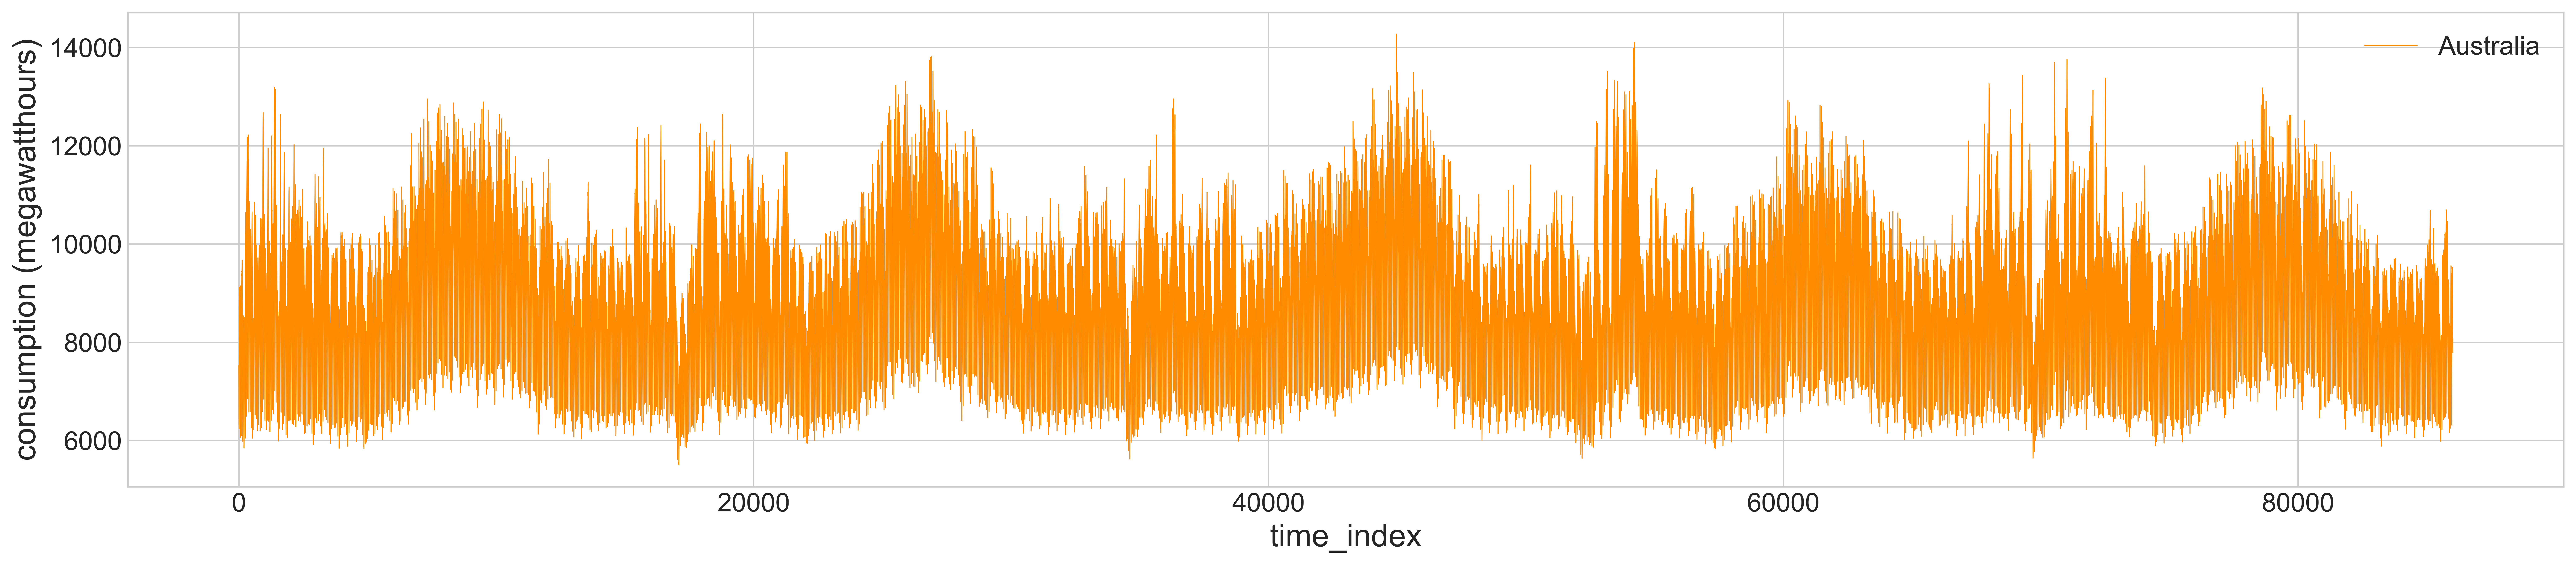

In [11]:
plt.style.use('seaborn-whitegrid')
fig = plt.figure(figsize=(25,5 ), dpi=600)
#fig.patch.set_facecolor('red')
ax = fig.add_subplot(1,1,1)
plt.rcParams.update({"font.size":15})
#plt.title("validation_acc",fontsize=13)

ax.plot(img, 'darkorange', label='Australia', linewidth=0.5)
ax.set_xlabel("time_index", fontsize=18)
ax.set_ylabel('consumption (megawatthours)', fontsize=18)
#plt.grid()
plt.legend()
plt.savefig('AUS.jpg',dpi=600,bbox_inches = 'tight')

plt.show()

42 -------------------------------
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 48, 4)]           0         
_________________________________________________________________
conv1d (Conv1D)              (None, 48, 48)            240       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 48, 48)            2352      
_________________________________________________________________
lstm (LSTM)                  (None, 48, 48)            18624     
_________________________________________________________________
lstm_1 (LSTM)                (None, 48)                18624     
_________________________________________________________________
dense (Dense)                (None, 48)                2352      
Total params: 42,192
Trainable params: 42,192
Non-trainable params: 0
______________________

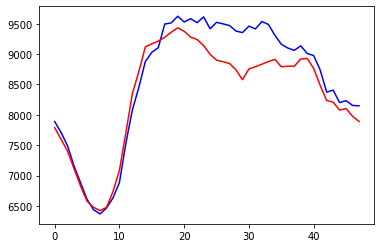

In [8]:
data = pd.read_csv('datas.csv', index_col=['date'], parse_dates=['date'])
pred_data, true_data, mapes = mainSet(data, '2010-11-01', '2010-11-02')

In [18]:
mapes

3.0456042129463

In [27]:
listTarg = []
listAim = []
for i in range(1,29):
    
    if i <10:
       
        #mainSet(data, '2010-12-'+'0'+str(i), '2010-12-'+'0'+str(i+1))
        listTarg.append('2010-11-'+'0'+str(i))
    else:
        #mainSet(data, '2010-12-'+str(i), '2010-12-'+str(i+1))
        listTarg.append('2010-11-'+str(i))

for i in range(2,30):
    if i <10:
       
        #mainSet(data, '2010-12-'+'0'+str(i), '2010-12-'+'0'+str(i+1))
        listAim.append('2010-11-'+'0'+str(i))
    else:
        #mainSet(data, '2010-12-'+str(i), '2010-12-'+str(i+1))
        listAim.append('2010-11-'+str(i))

In [28]:
listTarg, listAim

(['2010-11-01',
  '2010-11-02',
  '2010-11-03',
  '2010-11-04',
  '2010-11-05',
  '2010-11-06',
  '2010-11-07',
  '2010-11-08',
  '2010-11-09',
  '2010-11-10',
  '2010-11-11',
  '2010-11-12',
  '2010-11-13',
  '2010-11-14',
  '2010-11-15',
  '2010-11-16',
  '2010-11-17',
  '2010-11-18',
  '2010-11-19',
  '2010-11-20',
  '2010-11-21',
  '2010-11-22',
  '2010-11-23',
  '2010-11-24',
  '2010-11-25',
  '2010-11-26',
  '2010-11-27',
  '2010-11-28'],
 ['2010-11-02',
  '2010-11-03',
  '2010-11-04',
  '2010-11-05',
  '2010-11-06',
  '2010-11-07',
  '2010-11-08',
  '2010-11-09',
  '2010-11-10',
  '2010-11-11',
  '2010-11-12',
  '2010-11-13',
  '2010-11-14',
  '2010-11-15',
  '2010-11-16',
  '2010-11-17',
  '2010-11-18',
  '2010-11-19',
  '2010-11-20',
  '2010-11-21',
  '2010-11-22',
  '2010-11-23',
  '2010-11-24',
  '2010-11-25',
  '2010-11-26',
  '2010-11-27',
  '2010-11-28',
  '2010-11-29'])

42 -------------------------------
Model: "model_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_31 (InputLayer)        [(None, 48, 4)]           0         
_________________________________________________________________
conv1d_60 (Conv1D)           (None, 48, 48)            240       
_________________________________________________________________
conv1d_61 (Conv1D)           (None, 48, 48)            2352      
_________________________________________________________________
lstm_60 (LSTM)               (None, 48, 48)            18624     
_________________________________________________________________
lstm_61 (LSTM)               (None, 48)                18624     
_________________________________________________________________
dense_30 (Dense)             (None, 48)                2352      
Total params: 42,192
Trainable params: 42,192
Non-trainable params: 0
___________________

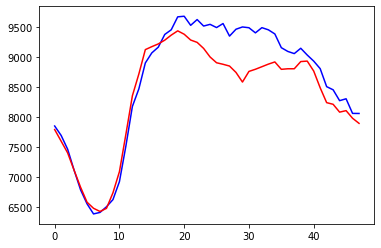

42 -------------------------------
Model: "model_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_32 (InputLayer)        [(None, 48, 4)]           0         
_________________________________________________________________
conv1d_62 (Conv1D)           (None, 48, 48)            240       
_________________________________________________________________
conv1d_63 (Conv1D)           (None, 48, 48)            2352      
_________________________________________________________________
lstm_62 (LSTM)               (None, 48, 48)            18624     
_________________________________________________________________
lstm_63 (LSTM)               (None, 48)                18624     
_________________________________________________________________
dense_31 (Dense)             (None, 48)                2352      
Total params: 42,192
Trainable params: 42,192
Non-trainable params: 0
___________________

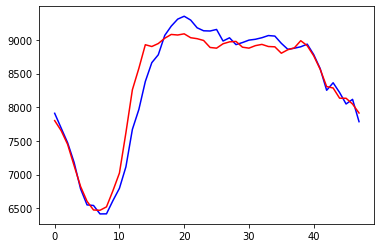

42 -------------------------------
Model: "model_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_33 (InputLayer)        [(None, 48, 4)]           0         
_________________________________________________________________
conv1d_64 (Conv1D)           (None, 48, 48)            240       
_________________________________________________________________
conv1d_65 (Conv1D)           (None, 48, 48)            2352      
_________________________________________________________________
lstm_64 (LSTM)               (None, 48, 48)            18624     
_________________________________________________________________
lstm_65 (LSTM)               (None, 48)                18624     
_________________________________________________________________
dense_32 (Dense)             (None, 48)                2352      
Total params: 42,192
Trainable params: 42,192
Non-trainable params: 0
___________________

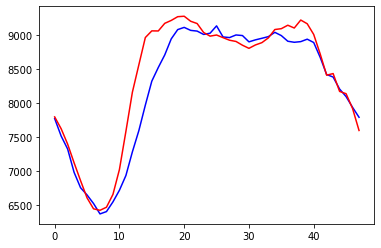

42 -------------------------------
Model: "model_33"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_34 (InputLayer)        [(None, 48, 4)]           0         
_________________________________________________________________
conv1d_66 (Conv1D)           (None, 48, 48)            240       
_________________________________________________________________
conv1d_67 (Conv1D)           (None, 48, 48)            2352      
_________________________________________________________________
lstm_66 (LSTM)               (None, 48, 48)            18624     
_________________________________________________________________
lstm_67 (LSTM)               (None, 48)                18624     
_________________________________________________________________
dense_33 (Dense)             (None, 48)                2352      
Total params: 42,192
Trainable params: 42,192
Non-trainable params: 0
___________________

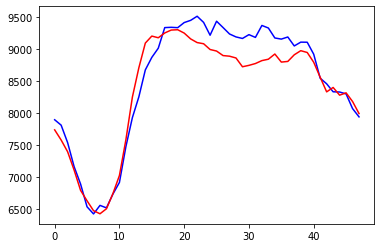

42 -------------------------------
Model: "model_34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_35 (InputLayer)        [(None, 48, 4)]           0         
_________________________________________________________________
conv1d_68 (Conv1D)           (None, 48, 48)            240       
_________________________________________________________________
conv1d_69 (Conv1D)           (None, 48, 48)            2352      
_________________________________________________________________
lstm_68 (LSTM)               (None, 48, 48)            18624     
_________________________________________________________________
lstm_69 (LSTM)               (None, 48)                18624     
_________________________________________________________________
dense_34 (Dense)             (None, 48)                2352      
Total params: 42,192
Trainable params: 42,192
Non-trainable params: 0
___________________

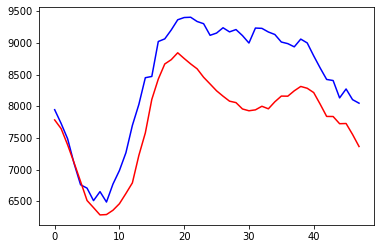

42 -------------------------------
Model: "model_35"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_36 (InputLayer)        [(None, 48, 4)]           0         
_________________________________________________________________
conv1d_70 (Conv1D)           (None, 48, 48)            240       
_________________________________________________________________
conv1d_71 (Conv1D)           (None, 48, 48)            2352      
_________________________________________________________________
lstm_70 (LSTM)               (None, 48, 48)            18624     
_________________________________________________________________
lstm_71 (LSTM)               (None, 48)                18624     
_________________________________________________________________
dense_35 (Dense)             (None, 48)                2352      
Total params: 42,192
Trainable params: 42,192
Non-trainable params: 0
___________________

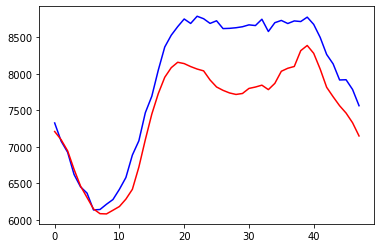

42 -------------------------------
Model: "model_36"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_37 (InputLayer)        [(None, 48, 4)]           0         
_________________________________________________________________
conv1d_72 (Conv1D)           (None, 48, 48)            240       
_________________________________________________________________
conv1d_73 (Conv1D)           (None, 48, 48)            2352      
_________________________________________________________________
lstm_72 (LSTM)               (None, 48, 48)            18624     
_________________________________________________________________
lstm_73 (LSTM)               (None, 48)                18624     
_________________________________________________________________
dense_36 (Dense)             (None, 48)                2352      
Total params: 42,192
Trainable params: 42,192
Non-trainable params: 0
___________________

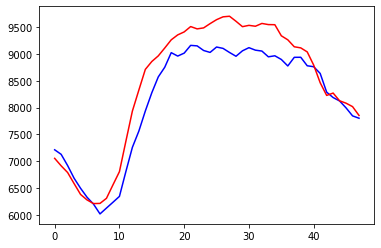

42 -------------------------------
Model: "model_37"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_38 (InputLayer)        [(None, 48, 4)]           0         
_________________________________________________________________
conv1d_74 (Conv1D)           (None, 48, 48)            240       
_________________________________________________________________
conv1d_75 (Conv1D)           (None, 48, 48)            2352      
_________________________________________________________________
lstm_74 (LSTM)               (None, 48, 48)            18624     
_________________________________________________________________
lstm_75 (LSTM)               (None, 48)                18624     
_________________________________________________________________
dense_37 (Dense)             (None, 48)                2352      
Total params: 42,192
Trainable params: 42,192
Non-trainable params: 0
___________________

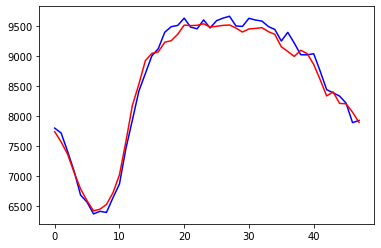

42 -------------------------------
Model: "model_38"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_39 (InputLayer)        [(None, 48, 4)]           0         
_________________________________________________________________
conv1d_76 (Conv1D)           (None, 48, 48)            240       
_________________________________________________________________
conv1d_77 (Conv1D)           (None, 48, 48)            2352      
_________________________________________________________________
lstm_76 (LSTM)               (None, 48, 48)            18624     
_________________________________________________________________
lstm_77 (LSTM)               (None, 48)                18624     
_________________________________________________________________
dense_38 (Dense)             (None, 48)                2352      
Total params: 42,192
Trainable params: 42,192
Non-trainable params: 0
___________________

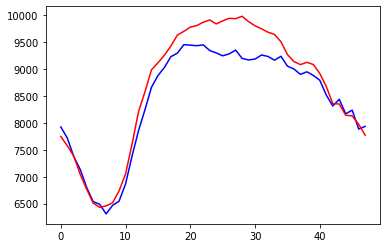

42 -------------------------------
Model: "model_39"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_40 (InputLayer)        [(None, 48, 4)]           0         
_________________________________________________________________
conv1d_78 (Conv1D)           (None, 48, 48)            240       
_________________________________________________________________
conv1d_79 (Conv1D)           (None, 48, 48)            2352      
_________________________________________________________________
lstm_78 (LSTM)               (None, 48, 48)            18624     
_________________________________________________________________
lstm_79 (LSTM)               (None, 48)                18624     
_________________________________________________________________
dense_39 (Dense)             (None, 48)                2352      
Total params: 42,192
Trainable params: 42,192
Non-trainable params: 0
___________________

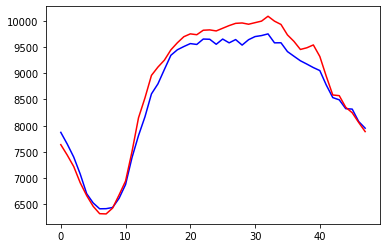

42 -------------------------------
Model: "model_40"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_41 (InputLayer)        [(None, 48, 4)]           0         
_________________________________________________________________
conv1d_80 (Conv1D)           (None, 48, 48)            240       
_________________________________________________________________
conv1d_81 (Conv1D)           (None, 48, 48)            2352      
_________________________________________________________________
lstm_80 (LSTM)               (None, 48, 48)            18624     
_________________________________________________________________
lstm_81 (LSTM)               (None, 48)                18624     
_________________________________________________________________
dense_40 (Dense)             (None, 48)                2352      
Total params: 42,192
Trainable params: 42,192
Non-trainable params: 0
___________________

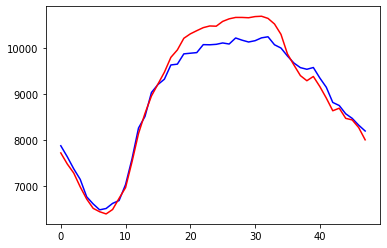

42 -------------------------------
Model: "model_41"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_42 (InputLayer)        [(None, 48, 4)]           0         
_________________________________________________________________
conv1d_82 (Conv1D)           (None, 48, 48)            240       
_________________________________________________________________
conv1d_83 (Conv1D)           (None, 48, 48)            2352      
_________________________________________________________________
lstm_82 (LSTM)               (None, 48, 48)            18624     
_________________________________________________________________
lstm_83 (LSTM)               (None, 48)                18624     
_________________________________________________________________
dense_41 (Dense)             (None, 48)                2352      
Total params: 42,192
Trainable params: 42,192
Non-trainable params: 0
___________________

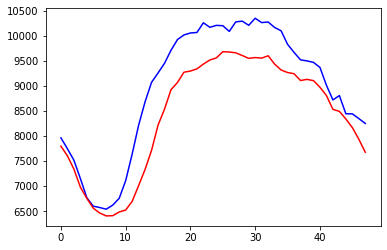

42 -------------------------------
Model: "model_42"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_43 (InputLayer)        [(None, 48, 4)]           0         
_________________________________________________________________
conv1d_84 (Conv1D)           (None, 48, 48)            240       
_________________________________________________________________
conv1d_85 (Conv1D)           (None, 48, 48)            2352      
_________________________________________________________________
lstm_84 (LSTM)               (None, 48, 48)            18624     
_________________________________________________________________
lstm_85 (LSTM)               (None, 48)                18624     
_________________________________________________________________
dense_42 (Dense)             (None, 48)                2352      
Total params: 42,192
Trainable params: 42,192
Non-trainable params: 0
___________________

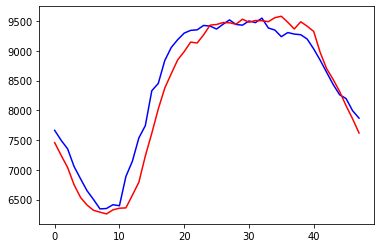

42 -------------------------------
Model: "model_43"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_44 (InputLayer)        [(None, 48, 4)]           0         
_________________________________________________________________
conv1d_86 (Conv1D)           (None, 48, 48)            240       
_________________________________________________________________
conv1d_87 (Conv1D)           (None, 48, 48)            2352      
_________________________________________________________________
lstm_86 (LSTM)               (None, 48, 48)            18624     
_________________________________________________________________
lstm_87 (LSTM)               (None, 48)                18624     
_________________________________________________________________
dense_43 (Dense)             (None, 48)                2352      
Total params: 42,192
Trainable params: 42,192
Non-trainable params: 0
___________________

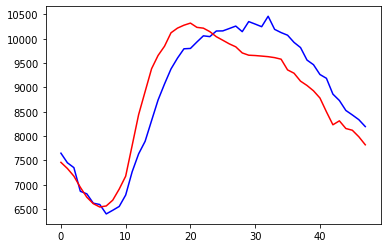

42 -------------------------------
Model: "model_44"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_45 (InputLayer)        [(None, 48, 4)]           0         
_________________________________________________________________
conv1d_88 (Conv1D)           (None, 48, 48)            240       
_________________________________________________________________
conv1d_89 (Conv1D)           (None, 48, 48)            2352      
_________________________________________________________________
lstm_88 (LSTM)               (None, 48, 48)            18624     
_________________________________________________________________
lstm_89 (LSTM)               (None, 48)                18624     
_________________________________________________________________
dense_44 (Dense)             (None, 48)                2352      
Total params: 42,192
Trainable params: 42,192
Non-trainable params: 0
___________________

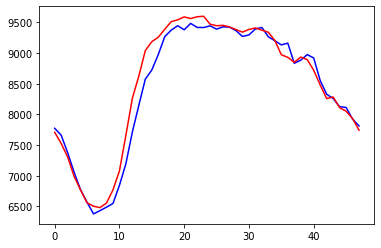

42 -------------------------------
Model: "model_45"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_46 (InputLayer)        [(None, 48, 4)]           0         
_________________________________________________________________
conv1d_90 (Conv1D)           (None, 48, 48)            240       
_________________________________________________________________
conv1d_91 (Conv1D)           (None, 48, 48)            2352      
_________________________________________________________________
lstm_90 (LSTM)               (None, 48, 48)            18624     
_________________________________________________________________
lstm_91 (LSTM)               (None, 48)                18624     
_________________________________________________________________
dense_45 (Dense)             (None, 48)                2352      
Total params: 42,192
Trainable params: 42,192
Non-trainable params: 0
___________________

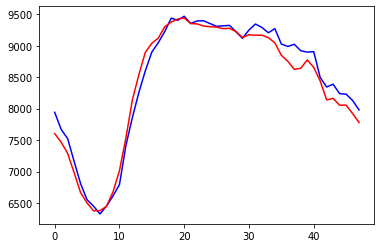

42 -------------------------------
Model: "model_46"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_47 (InputLayer)        [(None, 48, 4)]           0         
_________________________________________________________________
conv1d_92 (Conv1D)           (None, 48, 48)            240       
_________________________________________________________________
conv1d_93 (Conv1D)           (None, 48, 48)            2352      
_________________________________________________________________
lstm_92 (LSTM)               (None, 48, 48)            18624     
_________________________________________________________________
lstm_93 (LSTM)               (None, 48)                18624     
_________________________________________________________________
dense_46 (Dense)             (None, 48)                2352      
Total params: 42,192
Trainable params: 42,192
Non-trainable params: 0
___________________

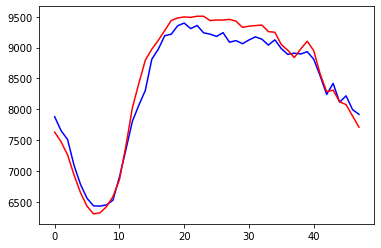

42 -------------------------------
Model: "model_47"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_48 (InputLayer)        [(None, 48, 4)]           0         
_________________________________________________________________
conv1d_94 (Conv1D)           (None, 48, 48)            240       
_________________________________________________________________
conv1d_95 (Conv1D)           (None, 48, 48)            2352      
_________________________________________________________________
lstm_94 (LSTM)               (None, 48, 48)            18624     
_________________________________________________________________
lstm_95 (LSTM)               (None, 48)                18624     
_________________________________________________________________
dense_47 (Dense)             (None, 48)                2352      
Total params: 42,192
Trainable params: 42,192
Non-trainable params: 0
___________________

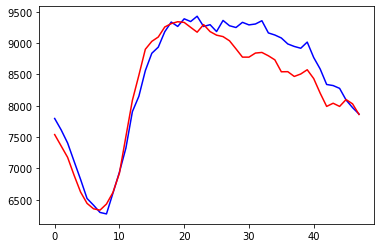

42 -------------------------------
Model: "model_48"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_49 (InputLayer)        [(None, 48, 4)]           0         
_________________________________________________________________
conv1d_96 (Conv1D)           (None, 48, 48)            240       
_________________________________________________________________
conv1d_97 (Conv1D)           (None, 48, 48)            2352      
_________________________________________________________________
lstm_96 (LSTM)               (None, 48, 48)            18624     
_________________________________________________________________
lstm_97 (LSTM)               (None, 48)                18624     
_________________________________________________________________
dense_48 (Dense)             (None, 48)                2352      
Total params: 42,192
Trainable params: 42,192
Non-trainable params: 0
___________________

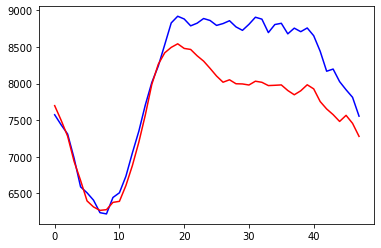

42 -------------------------------
Model: "model_49"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_50 (InputLayer)        [(None, 48, 4)]           0         
_________________________________________________________________
conv1d_98 (Conv1D)           (None, 48, 48)            240       
_________________________________________________________________
conv1d_99 (Conv1D)           (None, 48, 48)            2352      
_________________________________________________________________
lstm_98 (LSTM)               (None, 48, 48)            18624     
_________________________________________________________________
lstm_99 (LSTM)               (None, 48)                18624     
_________________________________________________________________
dense_49 (Dense)             (None, 48)                2352      
Total params: 42,192
Trainable params: 42,192
Non-trainable params: 0
___________________

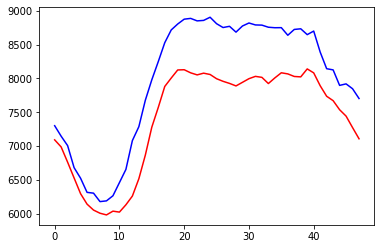

42 -------------------------------
Model: "model_50"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_51 (InputLayer)        [(None, 48, 4)]           0         
_________________________________________________________________
conv1d_100 (Conv1D)          (None, 48, 48)            240       
_________________________________________________________________
conv1d_101 (Conv1D)          (None, 48, 48)            2352      
_________________________________________________________________
lstm_100 (LSTM)              (None, 48, 48)            18624     
_________________________________________________________________
lstm_101 (LSTM)              (None, 48)                18624     
_________________________________________________________________
dense_50 (Dense)             (None, 48)                2352      
Total params: 42,192
Trainable params: 42,192
Non-trainable params: 0
___________________

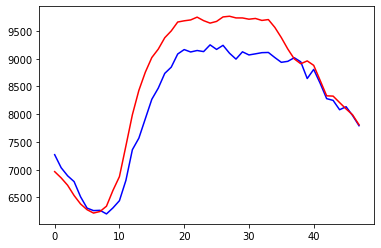

42 -------------------------------
Model: "model_51"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_52 (InputLayer)        [(None, 48, 4)]           0         
_________________________________________________________________
conv1d_102 (Conv1D)          (None, 48, 48)            240       
_________________________________________________________________
conv1d_103 (Conv1D)          (None, 48, 48)            2352      
_________________________________________________________________
lstm_102 (LSTM)              (None, 48, 48)            18624     
_________________________________________________________________
lstm_103 (LSTM)              (None, 48)                18624     
_________________________________________________________________
dense_51 (Dense)             (None, 48)                2352      
Total params: 42,192
Trainable params: 42,192
Non-trainable params: 0
___________________

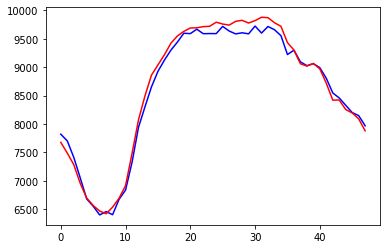

42 -------------------------------
Model: "model_52"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_53 (InputLayer)        [(None, 48, 4)]           0         
_________________________________________________________________
conv1d_104 (Conv1D)          (None, 48, 48)            240       
_________________________________________________________________
conv1d_105 (Conv1D)          (None, 48, 48)            2352      
_________________________________________________________________
lstm_104 (LSTM)              (None, 48, 48)            18624     
_________________________________________________________________
lstm_105 (LSTM)              (None, 48)                18624     
_________________________________________________________________
dense_52 (Dense)             (None, 48)                2352      
Total params: 42,192
Trainable params: 42,192
Non-trainable params: 0
___________________

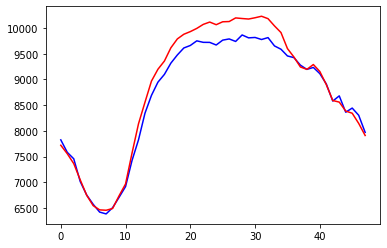

42 -------------------------------
Model: "model_53"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_54 (InputLayer)        [(None, 48, 4)]           0         
_________________________________________________________________
conv1d_106 (Conv1D)          (None, 48, 48)            240       
_________________________________________________________________
conv1d_107 (Conv1D)          (None, 48, 48)            2352      
_________________________________________________________________
lstm_106 (LSTM)              (None, 48, 48)            18624     
_________________________________________________________________
lstm_107 (LSTM)              (None, 48)                18624     
_________________________________________________________________
dense_53 (Dense)             (None, 48)                2352      
Total params: 42,192
Trainable params: 42,192
Non-trainable params: 0
___________________

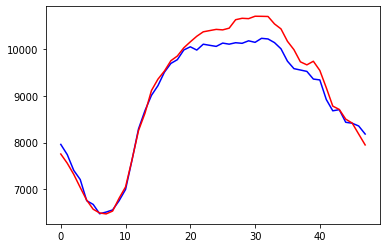

42 -------------------------------
Model: "model_54"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_55 (InputLayer)        [(None, 48, 4)]           0         
_________________________________________________________________
conv1d_108 (Conv1D)          (None, 48, 48)            240       
_________________________________________________________________
conv1d_109 (Conv1D)          (None, 48, 48)            2352      
_________________________________________________________________
lstm_108 (LSTM)              (None, 48, 48)            18624     
_________________________________________________________________
lstm_109 (LSTM)              (None, 48)                18624     
_________________________________________________________________
dense_54 (Dense)             (None, 48)                2352      
Total params: 42,192
Trainable params: 42,192
Non-trainable params: 0
___________________

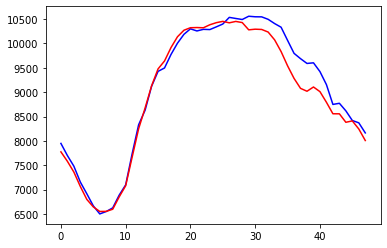

42 -------------------------------
Model: "model_55"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_56 (InputLayer)        [(None, 48, 4)]           0         
_________________________________________________________________
conv1d_110 (Conv1D)          (None, 48, 48)            240       
_________________________________________________________________
conv1d_111 (Conv1D)          (None, 48, 48)            2352      
_________________________________________________________________
lstm_110 (LSTM)              (None, 48, 48)            18624     
_________________________________________________________________
lstm_111 (LSTM)              (None, 48)                18624     
_________________________________________________________________
dense_55 (Dense)             (None, 48)                2352      
Total params: 42,192
Trainable params: 42,192
Non-trainable params: 0
___________________

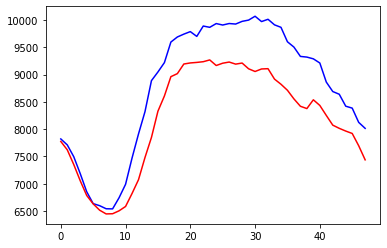

42 -------------------------------
Model: "model_56"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_57 (InputLayer)        [(None, 48, 4)]           0         
_________________________________________________________________
conv1d_112 (Conv1D)          (None, 48, 48)            240       
_________________________________________________________________
conv1d_113 (Conv1D)          (None, 48, 48)            2352      
_________________________________________________________________
lstm_112 (LSTM)              (None, 48, 48)            18624     
_________________________________________________________________
lstm_113 (LSTM)              (None, 48)                18624     
_________________________________________________________________
dense_56 (Dense)             (None, 48)                2352      
Total params: 42,192
Trainable params: 42,192
Non-trainable params: 0
___________________

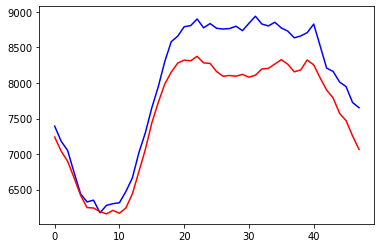

42 -------------------------------
Model: "model_57"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_58 (InputLayer)        [(None, 48, 4)]           0         
_________________________________________________________________
conv1d_114 (Conv1D)          (None, 48, 48)            240       
_________________________________________________________________
conv1d_115 (Conv1D)          (None, 48, 48)            2352      
_________________________________________________________________
lstm_114 (LSTM)              (None, 48, 48)            18624     
_________________________________________________________________
lstm_115 (LSTM)              (None, 48)                18624     
_________________________________________________________________
dense_57 (Dense)             (None, 48)                2352      
Total params: 42,192
Trainable params: 42,192
Non-trainable params: 0
___________________

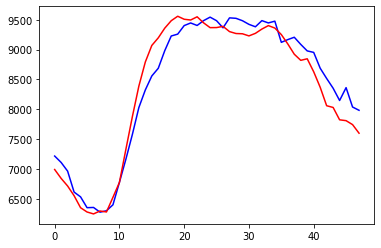

In [29]:
pred = np.array([])
true = np.array([])
mape_values = []
for i, j in zip(listTarg, listAim):
    data = pd.read_csv('datas.csv', index_col=['date'], parse_dates=['date'])
    pred_data_true, true_value, mapes=mainSet(data, i, j)
    pred = np.append(pred, pred_data_true)
    true = np.append(true, true_value)
    mape_values.append(mapes)

In [57]:
pred_DF = pd.DataFrame(pred.reshape(-1,48), index=listAim)

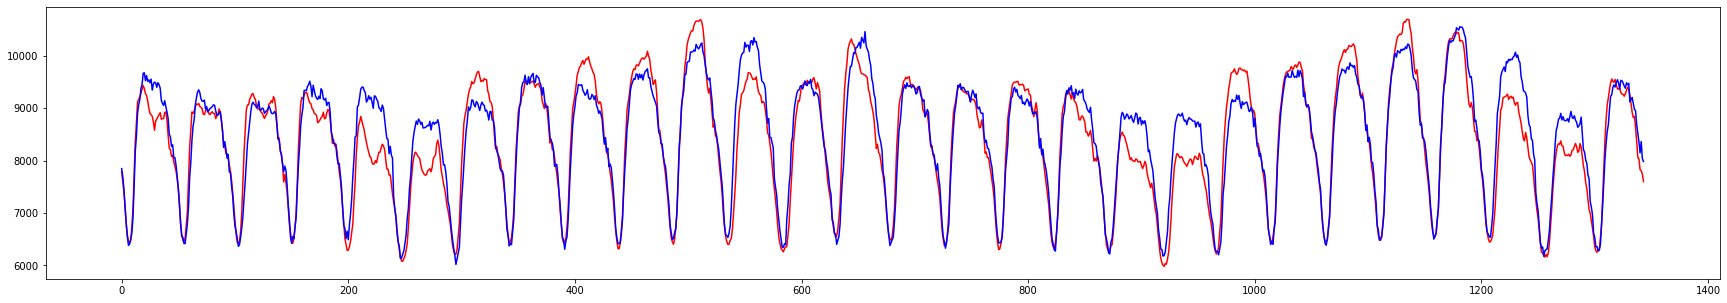

In [30]:
plt.figure(figsize=(30,5))
plt.plot(true, 'r')
plt.plot(pred, 'b')

In [61]:
pd.DataFrame(np.array(mape_values).reshape(-1,1),columns=['mape'],index=listAim).to_csv('mape_11.csv')

In [37]:
true.reshape(-1,48)

array([[7787.33, 7593.86, 7399.73, ..., 8102.67, 7976.04, 7890.84],
       [7800.91, 7652.09, 7447.8 , ..., 8132.35, 8046.54, 7913.71],
       [7794.35, 7619.99, 7393.5 , ..., 8135.81, 7918.63, 7594.1 ],
       ...,
       [7775.14, 7621.58, 7352.58, ..., 7921.39, 7696.89, 7437.95],
       [7239.79, 7042.03, 6899.01, ..., 7470.29, 7255.79, 7066.29],
       [6992.16, 6843.24, 6716.09, ..., 7809.72, 7743.59, 7599.99]])

In [48]:
trues = pd.DataFrame(true.reshape(-1,48), columns=[str(x) + 'h' for x in range(1,49)], index=listAim)

In [51]:
trues.to_csv('true_values_mon_11.csv')

In [53]:
preds = pd.DataFrame(pred.reshape(-1,48), columns=[str(x) + 'h' for x in range(1,49)], index=listAim)
preds.to_csv('pred_values_mon_11.csv')

### 对周末数据进行修正

In [64]:
#准备数据
#周末数据信息
weekend_index = np.array([['2009-01-02', '2009-01-03', '2009-01-04'],
       ['2009-01-09', '2009-01-10', '2009-01-11'],
       ['2009-01-16', '2009-01-17', '2009-01-18'],
       ['2009-01-23', '2009-01-24', '2009-01-25'],
       ['2009-01-30', '2009-01-31', '2009-02-01'],
       ['2009-02-06', '2009-02-07', '2009-02-08'],
       ['2009-02-13', '2009-02-14', '2009-02-15'],
       ['2009-02-20', '2009-02-21', '2009-02-22'],
       ['2009-02-27', '2009-02-28', '2009-03-01'],
       ['2009-03-06', '2009-03-07', '2009-03-08'],
       ['2009-03-13', '2009-03-14', '2009-03-15'],
       ['2009-03-20', '2009-03-21', '2009-03-22'],
       ['2009-03-27', '2009-03-28', '2009-03-29'],
       ['2009-04-03', '2009-04-04', '2009-04-05'],
       ['2009-04-10', '2009-04-11', '2009-04-12'],
       ['2009-04-17', '2009-04-18', '2009-04-19'],
       ['2009-04-24', '2009-04-25', '2009-04-26'],
       ['2009-05-01', '2009-05-02', '2009-05-03'],
       ['2009-05-08', '2009-05-09', '2009-05-10'],
       ['2009-05-15', '2009-05-16', '2009-05-17'],
       ['2009-05-22', '2009-05-23', '2009-05-24'],
       ['2009-05-29', '2009-05-30', '2009-05-31'],
       ['2009-06-05', '2009-06-06', '2009-06-07'],
       ['2009-06-12', '2009-06-13', '2009-06-14'],
       ['2009-06-19', '2009-06-20', '2009-06-21'],
       ['2009-06-26', '2009-06-27', '2009-06-28'],
       ['2009-07-03', '2009-07-04', '2009-07-05'],
       ['2009-07-10', '2009-07-11', '2009-07-12'],
       ['2009-07-17', '2009-07-18', '2009-07-19'],
       ['2009-07-24', '2009-07-25', '2009-07-26'],
       ['2009-07-31', '2009-08-01', '2009-08-02'],
       ['2009-08-07', '2009-08-08', '2009-08-09'],
       ['2009-08-14', '2009-08-15', '2009-08-16'],
       ['2009-08-21', '2009-08-22', '2009-08-23'],
       ['2009-08-28', '2009-08-29', '2009-08-30'],
       ['2009-09-04', '2009-09-05', '2009-09-06'],
       ['2009-09-11', '2009-09-12', '2009-09-13'],
       ['2009-09-18', '2009-09-19', '2009-09-20'],
       ['2009-09-25', '2009-09-26', '2009-09-27'],
       ['2009-10-02', '2009-10-03', '2009-10-04'],
       ['2009-10-09', '2009-10-10', '2009-10-11'],
       ['2009-10-16', '2009-10-17', '2009-10-18'],
       ['2009-10-23', '2009-10-24', '2009-10-25'],
       ['2009-10-30', '2009-10-31', '2009-11-01'],
       ['2009-11-06', '2009-11-07', '2009-11-08'],
       ['2009-11-13', '2009-11-14', '2009-11-15'],
       ['2009-11-20', '2009-11-21', '2009-11-22'],
       ['2009-11-27', '2009-11-28', '2009-11-29'],
       ['2009-12-04', '2009-12-05', '2009-12-06'],
       ['2009-12-11', '2009-12-12', '2009-12-13'],
       ['2009-12-18', '2009-12-19', '2009-12-20'],
       ['2009-12-25', '2009-12-26', '2009-12-27'],
       ['2010-01-01', '2010-01-02', '2010-01-03'],
       ['2010-01-08', '2010-01-09', '2010-01-10'],
       ['2010-01-15', '2010-01-16', '2010-01-17'],
       ['2010-01-22', '2010-01-23', '2010-01-24'],
       ['2010-01-29', '2010-01-30', '2010-01-31'],
       ['2010-02-05', '2010-02-06', '2010-02-07'],
       ['2010-02-12', '2010-02-13', '2010-02-14'],
       ['2010-02-19', '2010-02-20', '2010-02-21'],
       ['2010-02-26', '2010-02-27', '2010-02-28'],
       ['2010-03-05', '2010-03-06', '2010-03-07'],
       ['2010-03-12', '2010-03-13', '2010-03-14'],
       ['2010-03-19', '2010-03-20', '2010-03-21'],
       ['2010-03-26', '2010-03-27', '2010-03-28'],
       ['2010-04-02', '2010-04-03', '2010-04-04'],
       ['2010-04-09', '2010-04-10', '2010-04-11'],
       ['2010-04-16', '2010-04-17', '2010-04-18'],
       ['2010-04-23', '2010-04-24', '2010-04-25'],
       ['2010-04-30', '2010-05-01', '2010-05-02'],
       ['2010-05-07', '2010-05-08', '2010-05-09'],
       ['2010-05-14', '2010-05-15', '2010-05-16'],
       ['2010-05-21', '2010-05-22', '2010-05-23'],
       ['2010-05-28', '2010-05-29', '2010-05-30'],
       ['2010-06-04', '2010-06-05', '2010-06-06'],
       ['2010-06-11', '2010-06-12', '2010-06-13'],
       ['2010-06-18', '2010-06-19', '2010-06-20'],
       ['2010-06-25', '2010-06-26', '2010-06-27'],
       ['2010-07-02', '2010-07-03', '2010-07-04'],
       ['2010-07-09', '2010-07-10', '2010-07-11'],
       ['2010-07-16', '2010-07-17', '2010-07-18'],
       ['2010-07-23', '2010-07-24', '2010-07-25'],
       ['2010-07-30', '2010-07-31', '2010-08-01'],
       ['2010-08-06', '2010-08-07', '2010-08-08'],
       ['2010-08-13', '2010-08-14', '2010-08-15'],
       ['2010-08-20', '2010-08-21', '2010-08-22'],
       ['2010-08-27', '2010-08-28', '2010-08-29'],
       ['2010-09-03', '2010-09-04', '2010-09-05'],
       ['2010-09-10', '2010-09-11', '2010-09-12'],
       ['2010-09-17', '2010-09-18', '2010-09-19'],
       ['2010-09-24', '2010-09-25', '2010-09-26'],
       ['2010-10-01', '2010-10-02', '2010-10-03'],
       ['2010-10-08', '2010-10-09', '2010-10-10'],
       ['2010-10-15', '2010-10-16', '2010-10-17'],
       ['2010-10-22', '2010-10-23', '2010-10-24'],
       ['2010-10-29', '2010-10-30', '2010-10-31']])

70 -------------------------------
Model: "model_84"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_85 (InputLayer)        [(None, 48, 4)]           0         
_________________________________________________________________
conv1d_168 (Conv1D)          (None, 48, 48)            240       
_________________________________________________________________
conv1d_169 (Conv1D)          (None, 48, 48)            2352      
_________________________________________________________________
lstm_168 (LSTM)              (None, 48, 48)            18624     
_________________________________________________________________
lstm_169 (LSTM)              (None, 48, 64)            28928     
_________________________________________________________________
lstm_170 (LSTM)              (None, 48)                21696     
_________________________________________________________________
dense_84 (Dense)       

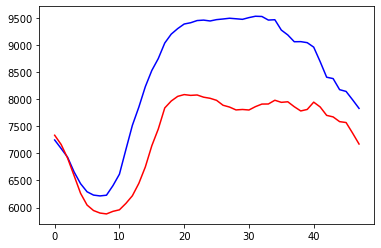

70 -------------------------------
Model: "model_85"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_86 (InputLayer)        [(None, 48, 4)]           0         
_________________________________________________________________
conv1d_170 (Conv1D)          (None, 48, 48)            240       
_________________________________________________________________
conv1d_171 (Conv1D)          (None, 48, 48)            2352      
_________________________________________________________________
lstm_171 (LSTM)              (None, 48, 48)            18624     
_________________________________________________________________
lstm_172 (LSTM)              (None, 48, 64)            28928     
_________________________________________________________________
lstm_173 (LSTM)              (None, 48)                21696     
_________________________________________________________________
dense_85 (Dense)       

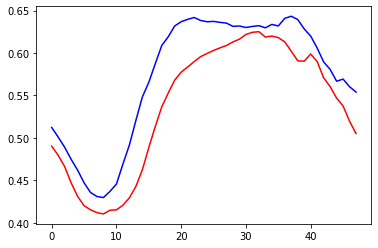

70 -------------------------------
Model: "model_86"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_87 (InputLayer)        [(None, 48, 4)]           0         
_________________________________________________________________
conv1d_172 (Conv1D)          (None, 48, 48)            240       
_________________________________________________________________
conv1d_173 (Conv1D)          (None, 48, 48)            2352      
_________________________________________________________________
lstm_174 (LSTM)              (None, 48, 48)            18624     
_________________________________________________________________
lstm_175 (LSTM)              (None, 48, 64)            28928     
_________________________________________________________________
lstm_176 (LSTM)              (None, 48)                21696     
_________________________________________________________________
dense_86 (Dense)       

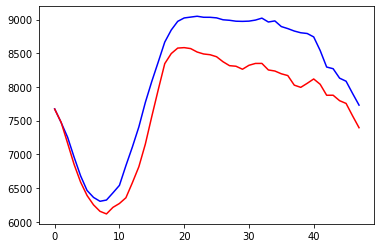

70 -------------------------------
Model: "model_87"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_88 (InputLayer)        [(None, 48, 4)]           0         
_________________________________________________________________
conv1d_174 (Conv1D)          (None, 48, 48)            240       
_________________________________________________________________
conv1d_175 (Conv1D)          (None, 48, 48)            2352      
_________________________________________________________________
lstm_177 (LSTM)              (None, 48, 48)            18624     
_________________________________________________________________
lstm_178 (LSTM)              (None, 48, 64)            28928     
_________________________________________________________________
lstm_179 (LSTM)              (None, 48)                21696     
_________________________________________________________________
dense_87 (Dense)       

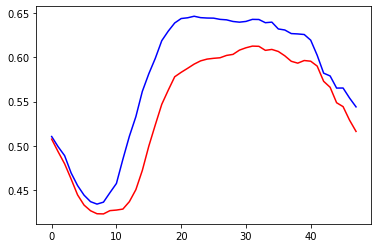

70 -------------------------------
Model: "model_88"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_89 (InputLayer)        [(None, 48, 4)]           0         
_________________________________________________________________
conv1d_176 (Conv1D)          (None, 48, 48)            240       
_________________________________________________________________
conv1d_177 (Conv1D)          (None, 48, 48)            2352      
_________________________________________________________________
lstm_180 (LSTM)              (None, 48, 48)            18624     
_________________________________________________________________
lstm_181 (LSTM)              (None, 48, 64)            28928     
_________________________________________________________________
lstm_182 (LSTM)              (None, 48)                21696     
_________________________________________________________________
dense_88 (Dense)       

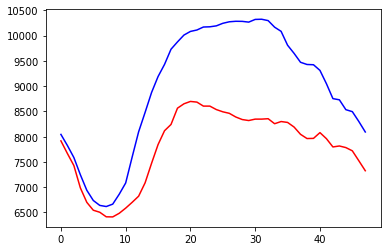

70 -------------------------------
Model: "model_89"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_90 (InputLayer)        [(None, 48, 4)]           0         
_________________________________________________________________
conv1d_178 (Conv1D)          (None, 48, 48)            240       
_________________________________________________________________
conv1d_179 (Conv1D)          (None, 48, 48)            2352      
_________________________________________________________________
lstm_183 (LSTM)              (None, 48, 48)            18624     
_________________________________________________________________
lstm_184 (LSTM)              (None, 48, 64)            28928     
_________________________________________________________________
lstm_185 (LSTM)              (None, 48)                21696     
_________________________________________________________________
dense_89 (Dense)       

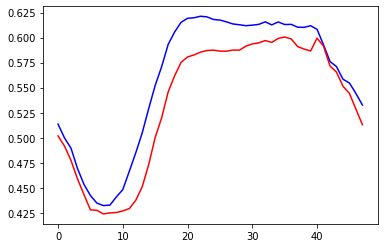

70 -------------------------------
Model: "model_90"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_91 (InputLayer)        [(None, 48, 4)]           0         
_________________________________________________________________
conv1d_180 (Conv1D)          (None, 48, 48)            240       
_________________________________________________________________
conv1d_181 (Conv1D)          (None, 48, 48)            2352      
_________________________________________________________________
lstm_186 (LSTM)              (None, 48, 48)            18624     
_________________________________________________________________
lstm_187 (LSTM)              (None, 48, 64)            28928     
_________________________________________________________________
lstm_188 (LSTM)              (None, 48)                21696     
_________________________________________________________________
dense_90 (Dense)       

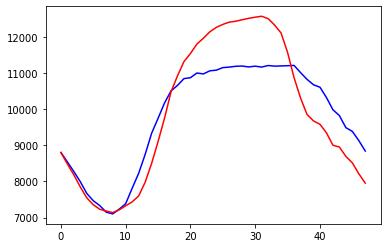

70 -------------------------------
Model: "model_91"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_92 (InputLayer)        [(None, 48, 4)]           0         
_________________________________________________________________
conv1d_182 (Conv1D)          (None, 48, 48)            240       
_________________________________________________________________
conv1d_183 (Conv1D)          (None, 48, 48)            2352      
_________________________________________________________________
lstm_189 (LSTM)              (None, 48, 48)            18624     
_________________________________________________________________
lstm_190 (LSTM)              (None, 48, 64)            28928     
_________________________________________________________________
lstm_191 (LSTM)              (None, 48)                21696     
_________________________________________________________________
dense_91 (Dense)       

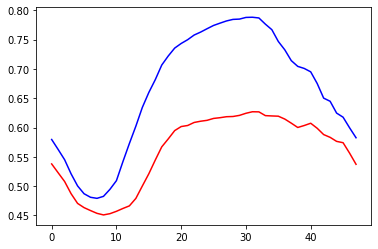

70 -------------------------------
Model: "model_92"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_93 (InputLayer)        [(None, 48, 4)]           0         
_________________________________________________________________
conv1d_184 (Conv1D)          (None, 48, 48)            240       
_________________________________________________________________
conv1d_185 (Conv1D)          (None, 48, 48)            2352      
_________________________________________________________________
lstm_192 (LSTM)              (None, 48, 48)            18624     
_________________________________________________________________
lstm_193 (LSTM)              (None, 48, 64)            28928     
_________________________________________________________________
lstm_194 (LSTM)              (None, 48)                21696     
_________________________________________________________________
dense_92 (Dense)       

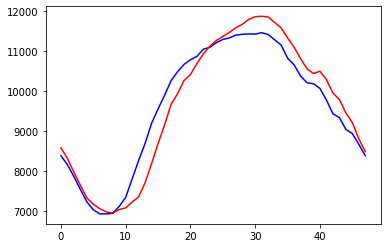

70 -------------------------------
Model: "model_93"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_94 (InputLayer)        [(None, 48, 4)]           0         
_________________________________________________________________
conv1d_186 (Conv1D)          (None, 48, 48)            240       
_________________________________________________________________
conv1d_187 (Conv1D)          (None, 48, 48)            2352      
_________________________________________________________________
lstm_195 (LSTM)              (None, 48, 48)            18624     
_________________________________________________________________
lstm_196 (LSTM)              (None, 48, 64)            28928     
_________________________________________________________________
lstm_197 (LSTM)              (None, 48)                21696     
_________________________________________________________________
dense_93 (Dense)       

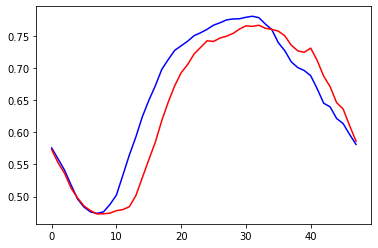

70 -------------------------------
Model: "model_94"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_95 (InputLayer)        [(None, 48, 4)]           0         
_________________________________________________________________
conv1d_188 (Conv1D)          (None, 48, 48)            240       
_________________________________________________________________
conv1d_189 (Conv1D)          (None, 48, 48)            2352      
_________________________________________________________________
lstm_198 (LSTM)              (None, 48, 48)            18624     
_________________________________________________________________
lstm_199 (LSTM)              (None, 48, 64)            28928     
_________________________________________________________________
lstm_200 (LSTM)              (None, 48)                21696     
_________________________________________________________________
dense_94 (Dense)       

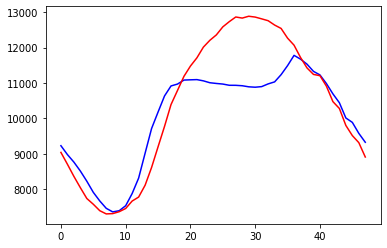

70 -------------------------------
Model: "model_95"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_96 (InputLayer)        [(None, 48, 4)]           0         
_________________________________________________________________
conv1d_190 (Conv1D)          (None, 48, 48)            240       
_________________________________________________________________
conv1d_191 (Conv1D)          (None, 48, 48)            2352      
_________________________________________________________________
lstm_201 (LSTM)              (None, 48, 48)            18624     
_________________________________________________________________
lstm_202 (LSTM)              (None, 48, 64)            28928     
_________________________________________________________________
lstm_203 (LSTM)              (None, 48)                21696     
_________________________________________________________________
dense_95 (Dense)       

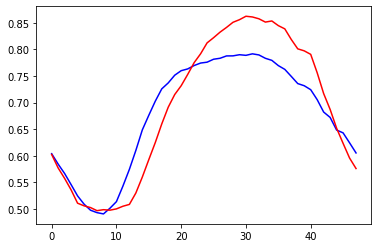

70 -------------------------------
Model: "model_96"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_97 (InputLayer)        [(None, 48, 4)]           0         
_________________________________________________________________
conv1d_192 (Conv1D)          (None, 48, 48)            240       
_________________________________________________________________
conv1d_193 (Conv1D)          (None, 48, 48)            2352      
_________________________________________________________________
lstm_204 (LSTM)              (None, 48, 48)            18624     
_________________________________________________________________
lstm_205 (LSTM)              (None, 48, 64)            28928     
_________________________________________________________________
lstm_206 (LSTM)              (None, 48)                21696     
_________________________________________________________________
dense_96 (Dense)       

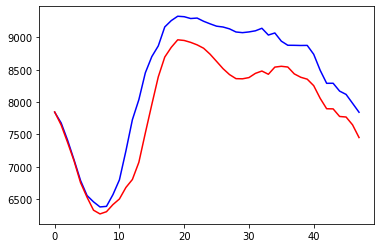

70 -------------------------------
Model: "model_97"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_98 (InputLayer)        [(None, 48, 4)]           0         
_________________________________________________________________
conv1d_194 (Conv1D)          (None, 48, 48)            240       
_________________________________________________________________
conv1d_195 (Conv1D)          (None, 48, 48)            2352      
_________________________________________________________________
lstm_207 (LSTM)              (None, 48, 48)            18624     
_________________________________________________________________
lstm_208 (LSTM)              (None, 48, 64)            28928     
_________________________________________________________________
lstm_209 (LSTM)              (None, 48)                21696     
_________________________________________________________________
dense_97 (Dense)       

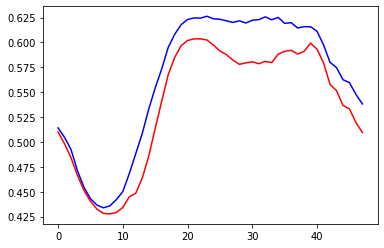

70 -------------------------------
Model: "model_98"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_99 (InputLayer)        [(None, 48, 4)]           0         
_________________________________________________________________
conv1d_196 (Conv1D)          (None, 48, 48)            240       
_________________________________________________________________
conv1d_197 (Conv1D)          (None, 48, 48)            2352      
_________________________________________________________________
lstm_210 (LSTM)              (None, 48, 48)            18624     
_________________________________________________________________
lstm_211 (LSTM)              (None, 48, 64)            28928     
_________________________________________________________________
lstm_212 (LSTM)              (None, 48)                21696     
_________________________________________________________________
dense_98 (Dense)       

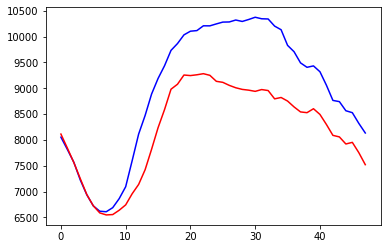

70 -------------------------------
Model: "model_99"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_100 (InputLayer)       [(None, 48, 4)]           0         
_________________________________________________________________
conv1d_198 (Conv1D)          (None, 48, 48)            240       
_________________________________________________________________
conv1d_199 (Conv1D)          (None, 48, 48)            2352      
_________________________________________________________________
lstm_213 (LSTM)              (None, 48, 48)            18624     
_________________________________________________________________
lstm_214 (LSTM)              (None, 48, 64)            28928     
_________________________________________________________________
lstm_215 (LSTM)              (None, 48)                21696     
_________________________________________________________________
dense_99 (Dense)       

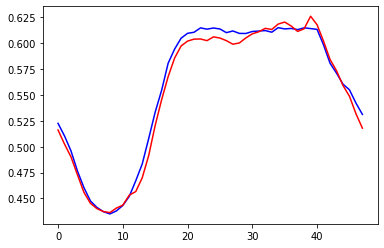

70 -------------------------------
Model: "model_100"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_101 (InputLayer)       [(None, 48, 4)]           0         
_________________________________________________________________
conv1d_200 (Conv1D)          (None, 48, 48)            240       
_________________________________________________________________
conv1d_201 (Conv1D)          (None, 48, 48)            2352      
_________________________________________________________________
lstm_216 (LSTM)              (None, 48, 48)            18624     
_________________________________________________________________
lstm_217 (LSTM)              (None, 48, 64)            28928     
_________________________________________________________________
lstm_218 (LSTM)              (None, 48)                21696     
_________________________________________________________________
dense_100 (Dense)     

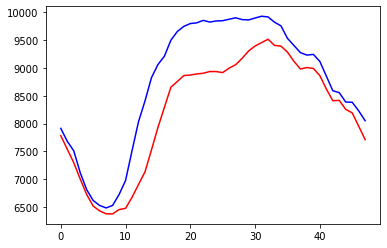

70 -------------------------------
Model: "model_101"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_102 (InputLayer)       [(None, 48, 4)]           0         
_________________________________________________________________
conv1d_202 (Conv1D)          (None, 48, 48)            240       
_________________________________________________________________
conv1d_203 (Conv1D)          (None, 48, 48)            2352      
_________________________________________________________________
lstm_219 (LSTM)              (None, 48, 48)            18624     
_________________________________________________________________
lstm_220 (LSTM)              (None, 48, 64)            28928     
_________________________________________________________________
lstm_221 (LSTM)              (None, 48)                21696     
_________________________________________________________________
dense_101 (Dense)     

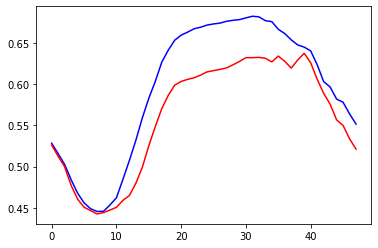

70 -------------------------------
Model: "model_102"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_103 (InputLayer)       [(None, 48, 4)]           0         
_________________________________________________________________
conv1d_204 (Conv1D)          (None, 48, 48)            240       
_________________________________________________________________
conv1d_205 (Conv1D)          (None, 48, 48)            2352      
_________________________________________________________________
lstm_222 (LSTM)              (None, 48, 48)            18624     
_________________________________________________________________
lstm_223 (LSTM)              (None, 48, 64)            28928     
_________________________________________________________________
lstm_224 (LSTM)              (None, 48)                21696     
_________________________________________________________________
dense_102 (Dense)     

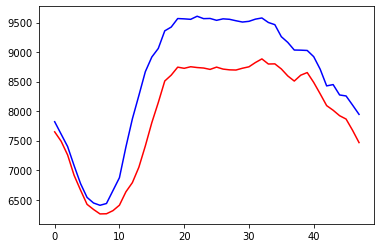

70 -------------------------------
Model: "model_103"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_104 (InputLayer)       [(None, 48, 4)]           0         
_________________________________________________________________
conv1d_206 (Conv1D)          (None, 48, 48)            240       
_________________________________________________________________
conv1d_207 (Conv1D)          (None, 48, 48)            2352      
_________________________________________________________________
lstm_225 (LSTM)              (None, 48, 48)            18624     
_________________________________________________________________
lstm_226 (LSTM)              (None, 48, 64)            28928     
_________________________________________________________________
lstm_227 (LSTM)              (None, 48)                21696     
_________________________________________________________________
dense_103 (Dense)     

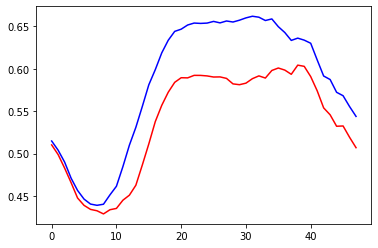

70 -------------------------------
Model: "model_104"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_105 (InputLayer)       [(None, 48, 4)]           0         
_________________________________________________________________
conv1d_208 (Conv1D)          (None, 48, 48)            240       
_________________________________________________________________
conv1d_209 (Conv1D)          (None, 48, 48)            2352      
_________________________________________________________________
lstm_228 (LSTM)              (None, 48, 48)            18624     
_________________________________________________________________
lstm_229 (LSTM)              (None, 48, 64)            28928     
_________________________________________________________________
lstm_230 (LSTM)              (None, 48)                21696     
_________________________________________________________________
dense_104 (Dense)     

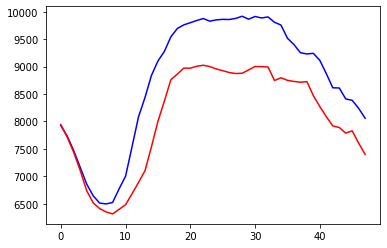

70 -------------------------------
Model: "model_105"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_106 (InputLayer)       [(None, 48, 4)]           0         
_________________________________________________________________
conv1d_210 (Conv1D)          (None, 48, 48)            240       
_________________________________________________________________
conv1d_211 (Conv1D)          (None, 48, 48)            2352      
_________________________________________________________________
lstm_231 (LSTM)              (None, 48, 48)            18624     
_________________________________________________________________
lstm_232 (LSTM)              (None, 48, 64)            28928     
_________________________________________________________________
lstm_233 (LSTM)              (None, 48)                21696     
_________________________________________________________________
dense_105 (Dense)     

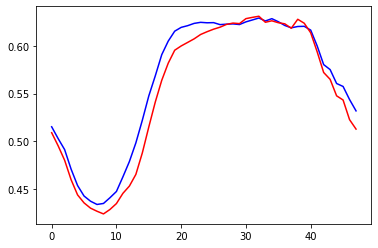

70 -------------------------------
Model: "model_106"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_107 (InputLayer)       [(None, 48, 4)]           0         
_________________________________________________________________
conv1d_212 (Conv1D)          (None, 48, 48)            240       
_________________________________________________________________
conv1d_213 (Conv1D)          (None, 48, 48)            2352      
_________________________________________________________________
lstm_234 (LSTM)              (None, 48, 48)            18624     
_________________________________________________________________
lstm_235 (LSTM)              (None, 48, 64)            28928     
_________________________________________________________________
lstm_236 (LSTM)              (None, 48)                21696     
_________________________________________________________________
dense_106 (Dense)     

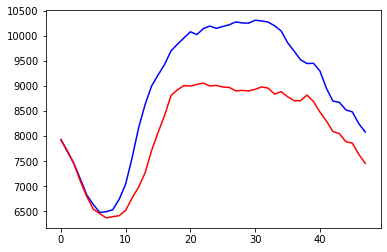

70 -------------------------------
Model: "model_107"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_108 (InputLayer)       [(None, 48, 4)]           0         
_________________________________________________________________
conv1d_214 (Conv1D)          (None, 48, 48)            240       
_________________________________________________________________
conv1d_215 (Conv1D)          (None, 48, 48)            2352      
_________________________________________________________________
lstm_237 (LSTM)              (None, 48, 48)            18624     
_________________________________________________________________
lstm_238 (LSTM)              (None, 48, 64)            28928     
_________________________________________________________________
lstm_239 (LSTM)              (None, 48)                21696     
_________________________________________________________________
dense_107 (Dense)     

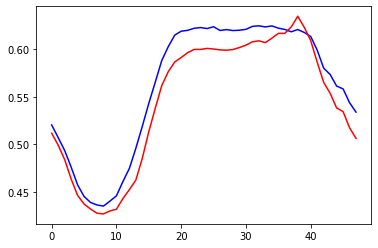

70 -------------------------------
Model: "model_108"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_109 (InputLayer)       [(None, 48, 4)]           0         
_________________________________________________________________
conv1d_216 (Conv1D)          (None, 48, 48)            240       
_________________________________________________________________
conv1d_217 (Conv1D)          (None, 48, 48)            2352      
_________________________________________________________________
lstm_240 (LSTM)              (None, 48, 48)            18624     
_________________________________________________________________
lstm_241 (LSTM)              (None, 48, 64)            28928     
_________________________________________________________________
lstm_242 (LSTM)              (None, 48)                21696     
_________________________________________________________________
dense_108 (Dense)     

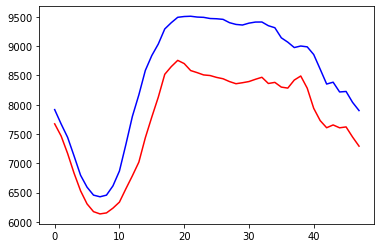

70 -------------------------------
Model: "model_109"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_110 (InputLayer)       [(None, 48, 4)]           0         
_________________________________________________________________
conv1d_218 (Conv1D)          (None, 48, 48)            240       
_________________________________________________________________
conv1d_219 (Conv1D)          (None, 48, 48)            2352      
_________________________________________________________________
lstm_243 (LSTM)              (None, 48, 48)            18624     
_________________________________________________________________
lstm_244 (LSTM)              (None, 48, 64)            28928     
_________________________________________________________________
lstm_245 (LSTM)              (None, 48)                21696     
_________________________________________________________________
dense_109 (Dense)     

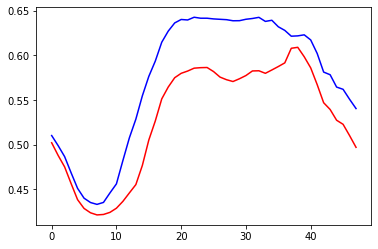

70 -------------------------------
Model: "model_110"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_111 (InputLayer)       [(None, 48, 4)]           0         
_________________________________________________________________
conv1d_220 (Conv1D)          (None, 48, 48)            240       
_________________________________________________________________
conv1d_221 (Conv1D)          (None, 48, 48)            2352      
_________________________________________________________________
lstm_246 (LSTM)              (None, 48, 48)            18624     
_________________________________________________________________
lstm_247 (LSTM)              (None, 48, 64)            28928     
_________________________________________________________________
lstm_248 (LSTM)              (None, 48)                21696     
_________________________________________________________________
dense_110 (Dense)     

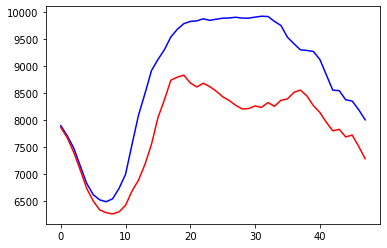

70 -------------------------------
Model: "model_111"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_112 (InputLayer)       [(None, 48, 4)]           0         
_________________________________________________________________
conv1d_222 (Conv1D)          (None, 48, 48)            240       
_________________________________________________________________
conv1d_223 (Conv1D)          (None, 48, 48)            2352      
_________________________________________________________________
lstm_249 (LSTM)              (None, 48, 48)            18624     
_________________________________________________________________
lstm_250 (LSTM)              (None, 48, 64)            28928     
_________________________________________________________________
lstm_251 (LSTM)              (None, 48)                21696     
_________________________________________________________________
dense_111 (Dense)     

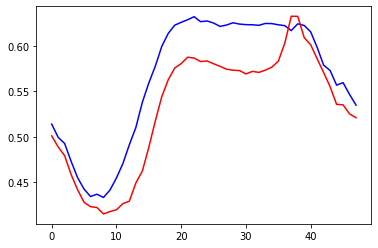

70 -------------------------------
Model: "model_112"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_113 (InputLayer)       [(None, 48, 4)]           0         
_________________________________________________________________
conv1d_224 (Conv1D)          (None, 48, 48)            240       
_________________________________________________________________
conv1d_225 (Conv1D)          (None, 48, 48)            2352      
_________________________________________________________________
lstm_252 (LSTM)              (None, 48, 48)            18624     
_________________________________________________________________
lstm_253 (LSTM)              (None, 48, 64)            28928     
_________________________________________________________________
lstm_254 (LSTM)              (None, 48)                21696     
_________________________________________________________________
dense_112 (Dense)     

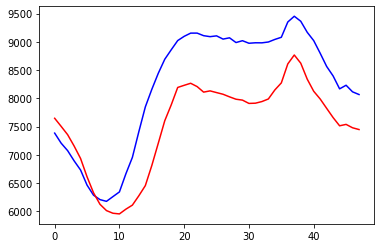

70 -------------------------------
Model: "model_113"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_114 (InputLayer)       [(None, 48, 4)]           0         
_________________________________________________________________
conv1d_226 (Conv1D)          (None, 48, 48)            240       
_________________________________________________________________
conv1d_227 (Conv1D)          (None, 48, 48)            2352      
_________________________________________________________________
lstm_255 (LSTM)              (None, 48, 48)            18624     
_________________________________________________________________
lstm_256 (LSTM)              (None, 48, 64)            28928     
_________________________________________________________________
lstm_257 (LSTM)              (None, 48)                21696     
_________________________________________________________________
dense_113 (Dense)     

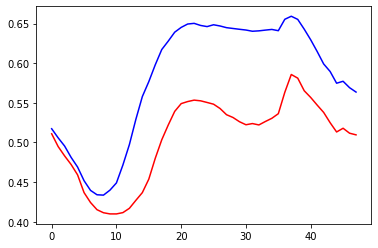

70 -------------------------------
Model: "model_114"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_115 (InputLayer)       [(None, 48, 4)]           0         
_________________________________________________________________
conv1d_228 (Conv1D)          (None, 48, 48)            240       
_________________________________________________________________
conv1d_229 (Conv1D)          (None, 48, 48)            2352      
_________________________________________________________________
lstm_258 (LSTM)              (None, 48, 48)            18624     
_________________________________________________________________
lstm_259 (LSTM)              (None, 48, 64)            28928     
_________________________________________________________________
lstm_260 (LSTM)              (None, 48)                21696     
_________________________________________________________________
dense_114 (Dense)     

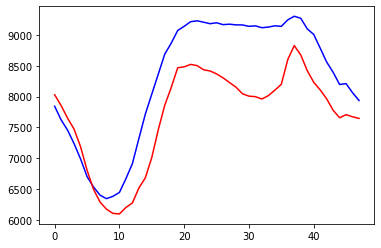

70 -------------------------------
Model: "model_115"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_116 (InputLayer)       [(None, 48, 4)]           0         
_________________________________________________________________
conv1d_230 (Conv1D)          (None, 48, 48)            240       
_________________________________________________________________
conv1d_231 (Conv1D)          (None, 48, 48)            2352      
_________________________________________________________________
lstm_261 (LSTM)              (None, 48, 48)            18624     
_________________________________________________________________
lstm_262 (LSTM)              (None, 48, 64)            28928     
_________________________________________________________________
lstm_263 (LSTM)              (None, 48)                21696     
_________________________________________________________________
dense_115 (Dense)     

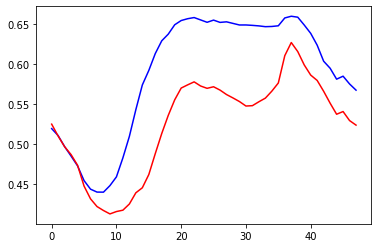

70 -------------------------------
Model: "model_116"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_117 (InputLayer)       [(None, 48, 4)]           0         
_________________________________________________________________
conv1d_232 (Conv1D)          (None, 48, 48)            240       
_________________________________________________________________
conv1d_233 (Conv1D)          (None, 48, 48)            2352      
_________________________________________________________________
lstm_264 (LSTM)              (None, 48, 48)            18624     
_________________________________________________________________
lstm_265 (LSTM)              (None, 48, 64)            28928     
_________________________________________________________________
lstm_266 (LSTM)              (None, 48)                21696     
_________________________________________________________________
dense_116 (Dense)     

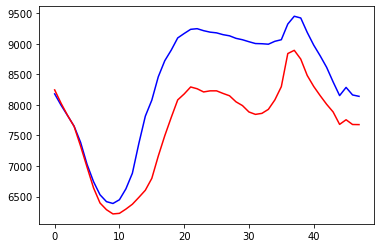

70 -------------------------------
Model: "model_117"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_118 (InputLayer)       [(None, 48, 4)]           0         
_________________________________________________________________
conv1d_234 (Conv1D)          (None, 48, 48)            240       
_________________________________________________________________
conv1d_235 (Conv1D)          (None, 48, 48)            2352      
_________________________________________________________________
lstm_267 (LSTM)              (None, 48, 48)            18624     
_________________________________________________________________
lstm_268 (LSTM)              (None, 48, 64)            28928     
_________________________________________________________________
lstm_269 (LSTM)              (None, 48)                21696     
_________________________________________________________________
dense_117 (Dense)     

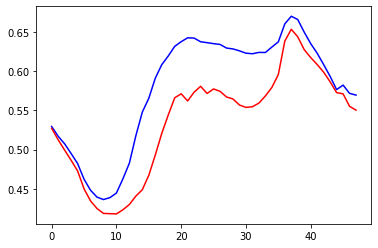

70 -------------------------------
Model: "model_118"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_119 (InputLayer)       [(None, 48, 4)]           0         
_________________________________________________________________
conv1d_236 (Conv1D)          (None, 48, 48)            240       
_________________________________________________________________
conv1d_237 (Conv1D)          (None, 48, 48)            2352      
_________________________________________________________________
lstm_270 (LSTM)              (None, 48, 48)            18624     
_________________________________________________________________
lstm_271 (LSTM)              (None, 48, 64)            28928     
_________________________________________________________________
lstm_272 (LSTM)              (None, 48)                21696     
_________________________________________________________________
dense_118 (Dense)     

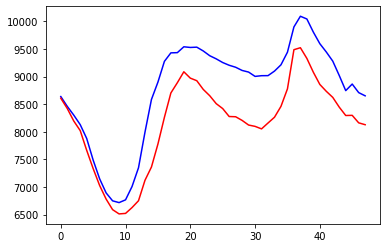

70 -------------------------------
Model: "model_119"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_120 (InputLayer)       [(None, 48, 4)]           0         
_________________________________________________________________
conv1d_238 (Conv1D)          (None, 48, 48)            240       
_________________________________________________________________
conv1d_239 (Conv1D)          (None, 48, 48)            2352      
_________________________________________________________________
lstm_273 (LSTM)              (None, 48, 48)            18624     
_________________________________________________________________
lstm_274 (LSTM)              (None, 48, 64)            28928     
_________________________________________________________________
lstm_275 (LSTM)              (None, 48)                21696     
_________________________________________________________________
dense_119 (Dense)     

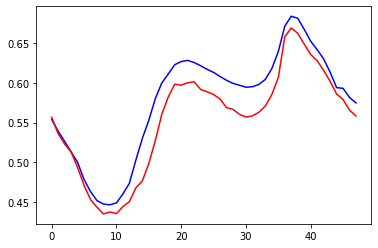

70 -------------------------------
Model: "model_120"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_121 (InputLayer)       [(None, 48, 4)]           0         
_________________________________________________________________
conv1d_240 (Conv1D)          (None, 48, 48)            240       
_________________________________________________________________
conv1d_241 (Conv1D)          (None, 48, 48)            2352      
_________________________________________________________________
lstm_276 (LSTM)              (None, 48, 48)            18624     
_________________________________________________________________
lstm_277 (LSTM)              (None, 48, 64)            28928     
_________________________________________________________________
lstm_278 (LSTM)              (None, 48)                21696     
_________________________________________________________________
dense_120 (Dense)     

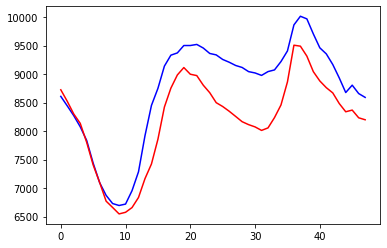

70 -------------------------------
Model: "model_121"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_122 (InputLayer)       [(None, 48, 4)]           0         
_________________________________________________________________
conv1d_242 (Conv1D)          (None, 48, 48)            240       
_________________________________________________________________
conv1d_243 (Conv1D)          (None, 48, 48)            2352      
_________________________________________________________________
lstm_279 (LSTM)              (None, 48, 48)            18624     
_________________________________________________________________
lstm_280 (LSTM)              (None, 48, 64)            28928     
_________________________________________________________________
lstm_281 (LSTM)              (None, 48)                21696     
_________________________________________________________________
dense_121 (Dense)     

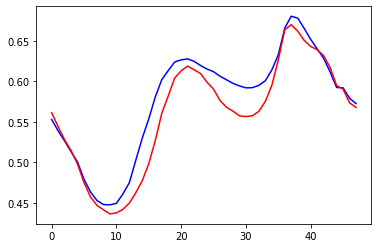

70 -------------------------------
Model: "model_122"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_123 (InputLayer)       [(None, 48, 4)]           0         
_________________________________________________________________
conv1d_244 (Conv1D)          (None, 48, 48)            240       
_________________________________________________________________
conv1d_245 (Conv1D)          (None, 48, 48)            2352      
_________________________________________________________________
lstm_282 (LSTM)              (None, 48, 48)            18624     
_________________________________________________________________
lstm_283 (LSTM)              (None, 48, 64)            28928     
_________________________________________________________________
lstm_284 (LSTM)              (None, 48)                21696     
_________________________________________________________________
dense_122 (Dense)     

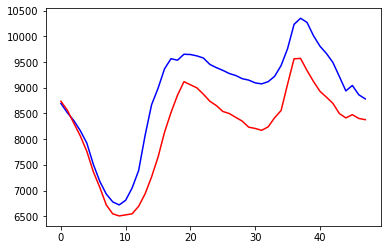

70 -------------------------------
Model: "model_123"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_124 (InputLayer)       [(None, 48, 4)]           0         
_________________________________________________________________
conv1d_246 (Conv1D)          (None, 48, 48)            240       
_________________________________________________________________
conv1d_247 (Conv1D)          (None, 48, 48)            2352      
_________________________________________________________________
lstm_285 (LSTM)              (None, 48, 48)            18624     
_________________________________________________________________
lstm_286 (LSTM)              (None, 48, 64)            28928     
_________________________________________________________________
lstm_287 (LSTM)              (None, 48)                21696     
_________________________________________________________________
dense_123 (Dense)     

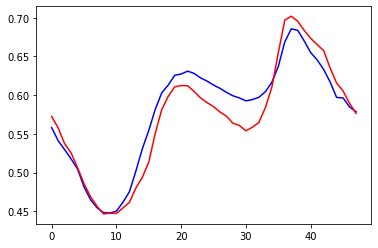

70 -------------------------------
Model: "model_124"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_125 (InputLayer)       [(None, 48, 4)]           0         
_________________________________________________________________
conv1d_248 (Conv1D)          (None, 48, 48)            240       
_________________________________________________________________
conv1d_249 (Conv1D)          (None, 48, 48)            2352      
_________________________________________________________________
lstm_288 (LSTM)              (None, 48, 48)            18624     
_________________________________________________________________
lstm_289 (LSTM)              (None, 48, 64)            28928     
_________________________________________________________________
lstm_290 (LSTM)              (None, 48)                21696     
_________________________________________________________________
dense_124 (Dense)     

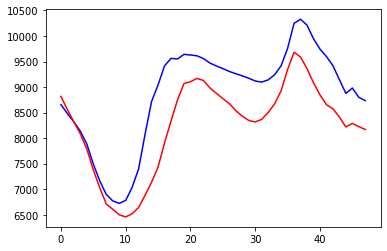

70 -------------------------------
Model: "model_125"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_126 (InputLayer)       [(None, 48, 4)]           0         
_________________________________________________________________
conv1d_250 (Conv1D)          (None, 48, 48)            240       
_________________________________________________________________
conv1d_251 (Conv1D)          (None, 48, 48)            2352      
_________________________________________________________________
lstm_291 (LSTM)              (None, 48, 48)            18624     
_________________________________________________________________
lstm_292 (LSTM)              (None, 48, 64)            28928     
_________________________________________________________________
lstm_293 (LSTM)              (None, 48)                21696     
_________________________________________________________________
dense_125 (Dense)     

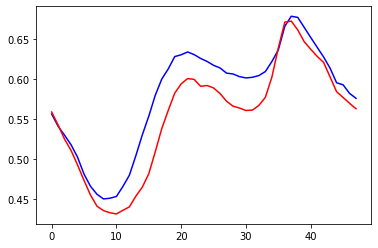

70 -------------------------------
Model: "model_126"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_127 (InputLayer)       [(None, 48, 4)]           0         
_________________________________________________________________
conv1d_252 (Conv1D)          (None, 48, 48)            240       
_________________________________________________________________
conv1d_253 (Conv1D)          (None, 48, 48)            2352      
_________________________________________________________________
lstm_294 (LSTM)              (None, 48, 48)            18624     
_________________________________________________________________
lstm_295 (LSTM)              (None, 48, 64)            28928     
_________________________________________________________________
lstm_296 (LSTM)              (None, 48)                21696     
_________________________________________________________________
dense_126 (Dense)     

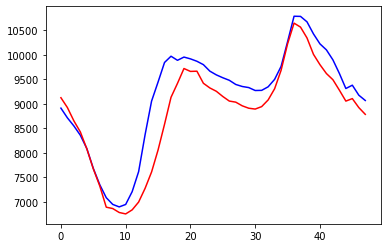

70 -------------------------------
Model: "model_127"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_128 (InputLayer)       [(None, 48, 4)]           0         
_________________________________________________________________
conv1d_254 (Conv1D)          (None, 48, 48)            240       
_________________________________________________________________
conv1d_255 (Conv1D)          (None, 48, 48)            2352      
_________________________________________________________________
lstm_297 (LSTM)              (None, 48, 48)            18624     
_________________________________________________________________
lstm_298 (LSTM)              (None, 48, 64)            28928     
_________________________________________________________________
lstm_299 (LSTM)              (None, 48)                21696     
_________________________________________________________________
dense_127 (Dense)     

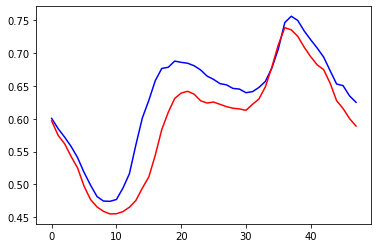

70 -------------------------------
Model: "model_128"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_129 (InputLayer)       [(None, 48, 4)]           0         
_________________________________________________________________
conv1d_256 (Conv1D)          (None, 48, 48)            240       
_________________________________________________________________
conv1d_257 (Conv1D)          (None, 48, 48)            2352      
_________________________________________________________________
lstm_300 (LSTM)              (None, 48, 48)            18624     
_________________________________________________________________
lstm_301 (LSTM)              (None, 48, 64)            28928     
_________________________________________________________________
lstm_302 (LSTM)              (None, 48)                21696     
_________________________________________________________________
dense_128 (Dense)     

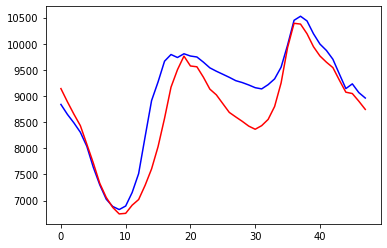

70 -------------------------------
Model: "model_129"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_130 (InputLayer)       [(None, 48, 4)]           0         
_________________________________________________________________
conv1d_258 (Conv1D)          (None, 48, 48)            240       
_________________________________________________________________
conv1d_259 (Conv1D)          (None, 48, 48)            2352      
_________________________________________________________________
lstm_303 (LSTM)              (None, 48, 48)            18624     
_________________________________________________________________
lstm_304 (LSTM)              (None, 48, 64)            28928     
_________________________________________________________________
lstm_305 (LSTM)              (None, 48)                21696     
_________________________________________________________________
dense_129 (Dense)     

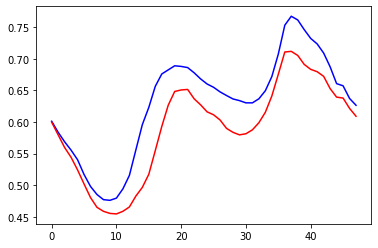

70 -------------------------------
Model: "model_130"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_131 (InputLayer)       [(None, 48, 4)]           0         
_________________________________________________________________
conv1d_260 (Conv1D)          (None, 48, 48)            240       
_________________________________________________________________
conv1d_261 (Conv1D)          (None, 48, 48)            2352      
_________________________________________________________________
lstm_306 (LSTM)              (None, 48, 48)            18624     
_________________________________________________________________
lstm_307 (LSTM)              (None, 48, 64)            28928     
_________________________________________________________________
lstm_308 (LSTM)              (None, 48)                21696     
_________________________________________________________________
dense_130 (Dense)     

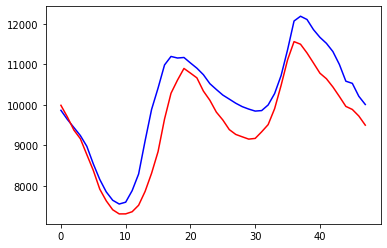

70 -------------------------------
Model: "model_131"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_132 (InputLayer)       [(None, 48, 4)]           0         
_________________________________________________________________
conv1d_262 (Conv1D)          (None, 48, 48)            240       
_________________________________________________________________
conv1d_263 (Conv1D)          (None, 48, 48)            2352      
_________________________________________________________________
lstm_309 (LSTM)              (None, 48, 48)            18624     
_________________________________________________________________
lstm_310 (LSTM)              (None, 48, 64)            28928     
_________________________________________________________________
lstm_311 (LSTM)              (None, 48)                21696     
_________________________________________________________________
dense_131 (Dense)     

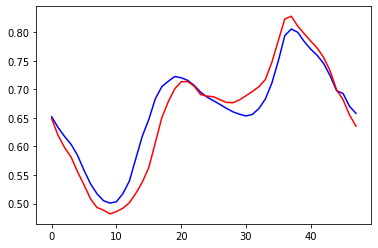

70 -------------------------------
Model: "model_132"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_133 (InputLayer)       [(None, 48, 4)]           0         
_________________________________________________________________
conv1d_264 (Conv1D)          (None, 48, 48)            240       
_________________________________________________________________
conv1d_265 (Conv1D)          (None, 48, 48)            2352      
_________________________________________________________________
lstm_312 (LSTM)              (None, 48, 48)            18624     
_________________________________________________________________
lstm_313 (LSTM)              (None, 48, 64)            28928     
_________________________________________________________________
lstm_314 (LSTM)              (None, 48)                21696     
_________________________________________________________________
dense_132 (Dense)     

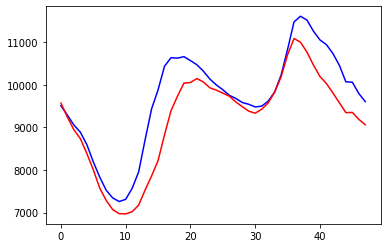

70 -------------------------------
Model: "model_133"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_134 (InputLayer)       [(None, 48, 4)]           0         
_________________________________________________________________
conv1d_266 (Conv1D)          (None, 48, 48)            240       
_________________________________________________________________
conv1d_267 (Conv1D)          (None, 48, 48)            2352      
_________________________________________________________________
lstm_315 (LSTM)              (None, 48, 48)            18624     
_________________________________________________________________
lstm_316 (LSTM)              (None, 48, 64)            28928     
_________________________________________________________________
lstm_317 (LSTM)              (None, 48)                21696     
_________________________________________________________________
dense_133 (Dense)     

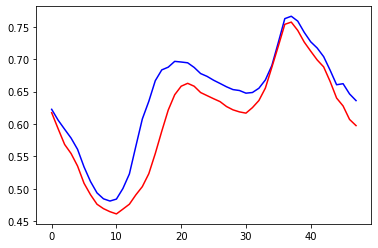

70 -------------------------------
Model: "model_134"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_135 (InputLayer)       [(None, 48, 4)]           0         
_________________________________________________________________
conv1d_268 (Conv1D)          (None, 48, 48)            240       
_________________________________________________________________
conv1d_269 (Conv1D)          (None, 48, 48)            2352      
_________________________________________________________________
lstm_318 (LSTM)              (None, 48, 48)            18624     
_________________________________________________________________
lstm_319 (LSTM)              (None, 48, 64)            28928     
_________________________________________________________________
lstm_320 (LSTM)              (None, 48)                21696     
_________________________________________________________________
dense_134 (Dense)     

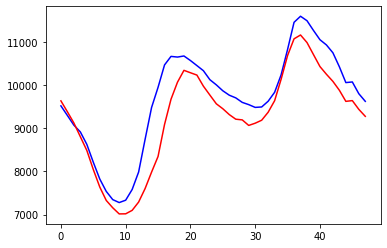

70 -------------------------------
Model: "model_135"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_136 (InputLayer)       [(None, 48, 4)]           0         
_________________________________________________________________
conv1d_270 (Conv1D)          (None, 48, 48)            240       
_________________________________________________________________
conv1d_271 (Conv1D)          (None, 48, 48)            2352      
_________________________________________________________________
lstm_321 (LSTM)              (None, 48, 48)            18624     
_________________________________________________________________
lstm_322 (LSTM)              (None, 48, 64)            28928     
_________________________________________________________________
lstm_323 (LSTM)              (None, 48)                21696     
_________________________________________________________________
dense_135 (Dense)     

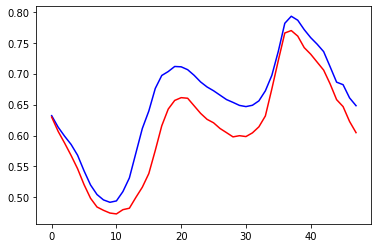

70 -------------------------------
Model: "model_136"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_137 (InputLayer)       [(None, 48, 4)]           0         
_________________________________________________________________
conv1d_272 (Conv1D)          (None, 48, 48)            240       
_________________________________________________________________
conv1d_273 (Conv1D)          (None, 48, 48)            2352      
_________________________________________________________________
lstm_324 (LSTM)              (None, 48, 48)            18624     
_________________________________________________________________
lstm_325 (LSTM)              (None, 48, 64)            28928     
_________________________________________________________________
lstm_326 (LSTM)              (None, 48)                21696     
_________________________________________________________________
dense_136 (Dense)     

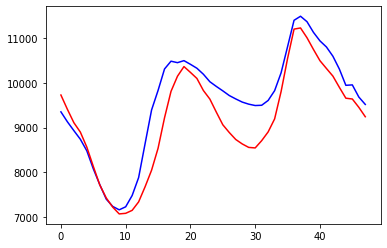

70 -------------------------------
Model: "model_137"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_138 (InputLayer)       [(None, 48, 4)]           0         
_________________________________________________________________
conv1d_274 (Conv1D)          (None, 48, 48)            240       
_________________________________________________________________
conv1d_275 (Conv1D)          (None, 48, 48)            2352      
_________________________________________________________________
lstm_327 (LSTM)              (None, 48, 48)            18624     
_________________________________________________________________
lstm_328 (LSTM)              (None, 48, 64)            28928     
_________________________________________________________________
lstm_329 (LSTM)              (None, 48)                21696     
_________________________________________________________________
dense_137 (Dense)     

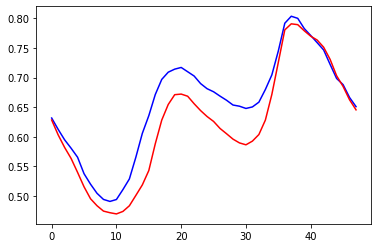

70 -------------------------------
Model: "model_138"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_139 (InputLayer)       [(None, 48, 4)]           0         
_________________________________________________________________
conv1d_276 (Conv1D)          (None, 48, 48)            240       
_________________________________________________________________
conv1d_277 (Conv1D)          (None, 48, 48)            2352      
_________________________________________________________________
lstm_330 (LSTM)              (None, 48, 48)            18624     
_________________________________________________________________
lstm_331 (LSTM)              (None, 48, 64)            28928     
_________________________________________________________________
lstm_332 (LSTM)              (None, 48)                21696     
_________________________________________________________________
dense_138 (Dense)     

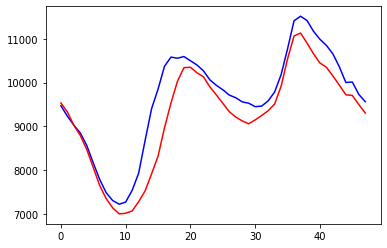

70 -------------------------------
Model: "model_139"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_140 (InputLayer)       [(None, 48, 4)]           0         
_________________________________________________________________
conv1d_278 (Conv1D)          (None, 48, 48)            240       
_________________________________________________________________
conv1d_279 (Conv1D)          (None, 48, 48)            2352      
_________________________________________________________________
lstm_333 (LSTM)              (None, 48, 48)            18624     
_________________________________________________________________
lstm_334 (LSTM)              (None, 48, 64)            28928     
_________________________________________________________________
lstm_335 (LSTM)              (None, 48)                21696     
_________________________________________________________________
dense_139 (Dense)     

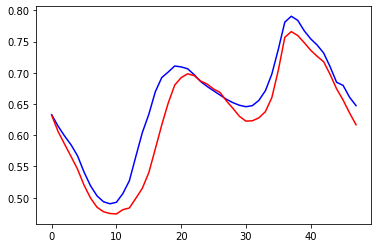

70 -------------------------------
Model: "model_140"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_141 (InputLayer)       [(None, 48, 4)]           0         
_________________________________________________________________
conv1d_280 (Conv1D)          (None, 48, 48)            240       
_________________________________________________________________
conv1d_281 (Conv1D)          (None, 48, 48)            2352      
_________________________________________________________________
lstm_336 (LSTM)              (None, 48, 48)            18624     
_________________________________________________________________
lstm_337 (LSTM)              (None, 48, 64)            28928     
_________________________________________________________________
lstm_338 (LSTM)              (None, 48)                21696     
_________________________________________________________________
dense_140 (Dense)     

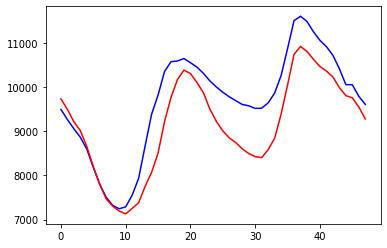

70 -------------------------------
Model: "model_141"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_142 (InputLayer)       [(None, 48, 4)]           0         
_________________________________________________________________
conv1d_282 (Conv1D)          (None, 48, 48)            240       
_________________________________________________________________
conv1d_283 (Conv1D)          (None, 48, 48)            2352      
_________________________________________________________________
lstm_339 (LSTM)              (None, 48, 48)            18624     
_________________________________________________________________
lstm_340 (LSTM)              (None, 48, 64)            28928     
_________________________________________________________________
lstm_341 (LSTM)              (None, 48)                21696     
_________________________________________________________________
dense_141 (Dense)     

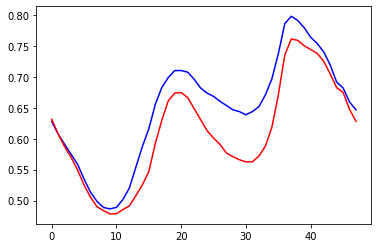

70 -------------------------------
Model: "model_142"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_143 (InputLayer)       [(None, 48, 4)]           0         
_________________________________________________________________
conv1d_284 (Conv1D)          (None, 48, 48)            240       
_________________________________________________________________
conv1d_285 (Conv1D)          (None, 48, 48)            2352      
_________________________________________________________________
lstm_342 (LSTM)              (None, 48, 48)            18624     
_________________________________________________________________
lstm_343 (LSTM)              (None, 48, 64)            28928     
_________________________________________________________________
lstm_344 (LSTM)              (None, 48)                21696     
_________________________________________________________________
dense_142 (Dense)     

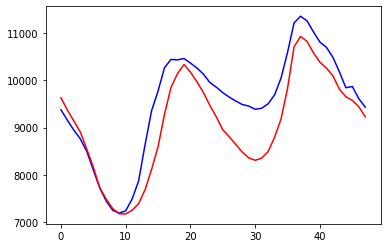

70 -------------------------------
Model: "model_143"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_144 (InputLayer)       [(None, 48, 4)]           0         
_________________________________________________________________
conv1d_286 (Conv1D)          (None, 48, 48)            240       
_________________________________________________________________
conv1d_287 (Conv1D)          (None, 48, 48)            2352      
_________________________________________________________________
lstm_345 (LSTM)              (None, 48, 48)            18624     
_________________________________________________________________
lstm_346 (LSTM)              (None, 48, 64)            28928     
_________________________________________________________________
lstm_347 (LSTM)              (None, 48)                21696     
_________________________________________________________________
dense_143 (Dense)     

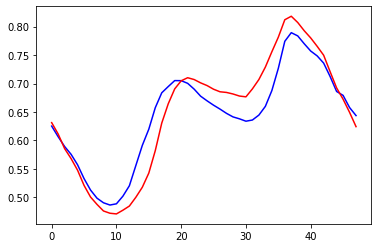

70 -------------------------------
Model: "model_144"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_145 (InputLayer)       [(None, 48, 4)]           0         
_________________________________________________________________
conv1d_288 (Conv1D)          (None, 48, 48)            240       
_________________________________________________________________
conv1d_289 (Conv1D)          (None, 48, 48)            2352      
_________________________________________________________________
lstm_348 (LSTM)              (None, 48, 48)            18624     
_________________________________________________________________
lstm_349 (LSTM)              (None, 48, 64)            28928     
_________________________________________________________________
lstm_350 (LSTM)              (None, 48)                21696     
_________________________________________________________________
dense_144 (Dense)     

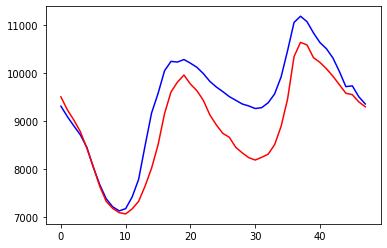

70 -------------------------------
Model: "model_145"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_146 (InputLayer)       [(None, 48, 4)]           0         
_________________________________________________________________
conv1d_290 (Conv1D)          (None, 48, 48)            240       
_________________________________________________________________
conv1d_291 (Conv1D)          (None, 48, 48)            2352      
_________________________________________________________________
lstm_351 (LSTM)              (None, 48, 48)            18624     
_________________________________________________________________
lstm_352 (LSTM)              (None, 48, 64)            28928     
_________________________________________________________________
lstm_353 (LSTM)              (None, 48)                21696     
_________________________________________________________________
dense_145 (Dense)     

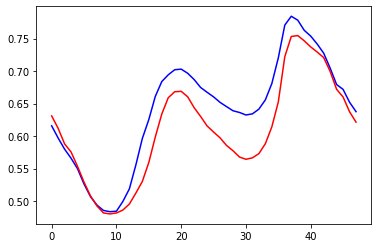

70 -------------------------------
Model: "model_146"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_147 (InputLayer)       [(None, 48, 4)]           0         
_________________________________________________________________
conv1d_292 (Conv1D)          (None, 48, 48)            240       
_________________________________________________________________
conv1d_293 (Conv1D)          (None, 48, 48)            2352      
_________________________________________________________________
lstm_354 (LSTM)              (None, 48, 48)            18624     
_________________________________________________________________
lstm_355 (LSTM)              (None, 48, 64)            28928     
_________________________________________________________________
lstm_356 (LSTM)              (None, 48)                21696     
_________________________________________________________________
dense_146 (Dense)     

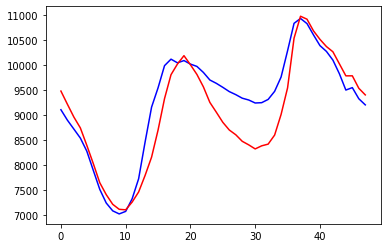

70 -------------------------------
Model: "model_147"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_148 (InputLayer)       [(None, 48, 4)]           0         
_________________________________________________________________
conv1d_294 (Conv1D)          (None, 48, 48)            240       
_________________________________________________________________
conv1d_295 (Conv1D)          (None, 48, 48)            2352      
_________________________________________________________________
lstm_357 (LSTM)              (None, 48, 48)            18624     
_________________________________________________________________
lstm_358 (LSTM)              (None, 48, 64)            28928     
_________________________________________________________________
lstm_359 (LSTM)              (None, 48)                21696     
_________________________________________________________________
dense_147 (Dense)     

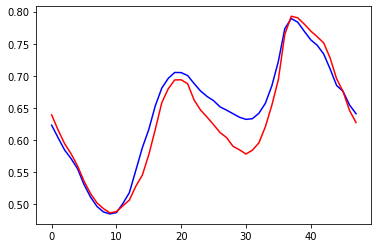

70 -------------------------------
Model: "model_148"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_149 (InputLayer)       [(None, 48, 4)]           0         
_________________________________________________________________
conv1d_296 (Conv1D)          (None, 48, 48)            240       
_________________________________________________________________
conv1d_297 (Conv1D)          (None, 48, 48)            2352      
_________________________________________________________________
lstm_360 (LSTM)              (None, 48, 48)            18624     
_________________________________________________________________
lstm_361 (LSTM)              (None, 48, 64)            28928     
_________________________________________________________________
lstm_362 (LSTM)              (None, 48)                21696     
_________________________________________________________________
dense_148 (Dense)     

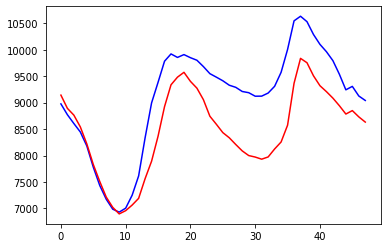

70 -------------------------------
Model: "model_149"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_150 (InputLayer)       [(None, 48, 4)]           0         
_________________________________________________________________
conv1d_298 (Conv1D)          (None, 48, 48)            240       
_________________________________________________________________
conv1d_299 (Conv1D)          (None, 48, 48)            2352      
_________________________________________________________________
lstm_363 (LSTM)              (None, 48, 48)            18624     
_________________________________________________________________
lstm_364 (LSTM)              (None, 48, 64)            28928     
_________________________________________________________________
lstm_365 (LSTM)              (None, 48)                21696     
_________________________________________________________________
dense_149 (Dense)     

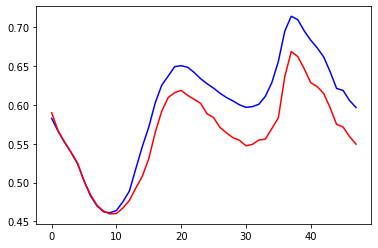

70 -------------------------------
Model: "model_150"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_151 (InputLayer)       [(None, 48, 4)]           0         
_________________________________________________________________
conv1d_300 (Conv1D)          (None, 48, 48)            240       
_________________________________________________________________
conv1d_301 (Conv1D)          (None, 48, 48)            2352      
_________________________________________________________________
lstm_366 (LSTM)              (None, 48, 48)            18624     
_________________________________________________________________
lstm_367 (LSTM)              (None, 48, 64)            28928     
_________________________________________________________________
lstm_368 (LSTM)              (None, 48)                21696     
_________________________________________________________________
dense_150 (Dense)     

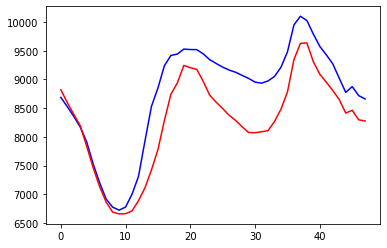

70 -------------------------------
Model: "model_151"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_152 (InputLayer)       [(None, 48, 4)]           0         
_________________________________________________________________
conv1d_302 (Conv1D)          (None, 48, 48)            240       
_________________________________________________________________
conv1d_303 (Conv1D)          (None, 48, 48)            2352      
_________________________________________________________________
lstm_369 (LSTM)              (None, 48, 48)            18624     
_________________________________________________________________
lstm_370 (LSTM)              (None, 48, 64)            28928     
_________________________________________________________________
lstm_371 (LSTM)              (None, 48)                21696     
_________________________________________________________________
dense_151 (Dense)     

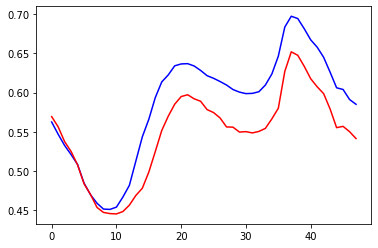

70 -------------------------------
Model: "model_152"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_153 (InputLayer)       [(None, 48, 4)]           0         
_________________________________________________________________
conv1d_304 (Conv1D)          (None, 48, 48)            240       
_________________________________________________________________
conv1d_305 (Conv1D)          (None, 48, 48)            2352      
_________________________________________________________________
lstm_372 (LSTM)              (None, 48, 48)            18624     
_________________________________________________________________
lstm_373 (LSTM)              (None, 48, 64)            28928     
_________________________________________________________________
lstm_374 (LSTM)              (None, 48)                21696     
_________________________________________________________________
dense_152 (Dense)     

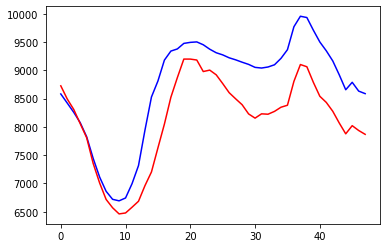

70 -------------------------------
Model: "model_153"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_154 (InputLayer)       [(None, 48, 4)]           0         
_________________________________________________________________
conv1d_306 (Conv1D)          (None, 48, 48)            240       
_________________________________________________________________
conv1d_307 (Conv1D)          (None, 48, 48)            2352      
_________________________________________________________________
lstm_375 (LSTM)              (None, 48, 48)            18624     
_________________________________________________________________
lstm_376 (LSTM)              (None, 48, 64)            28928     
_________________________________________________________________
lstm_377 (LSTM)              (None, 48)                21696     
_________________________________________________________________
dense_153 (Dense)     

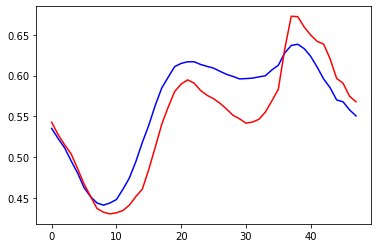

70 -------------------------------
Model: "model_154"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_155 (InputLayer)       [(None, 48, 4)]           0         
_________________________________________________________________
conv1d_308 (Conv1D)          (None, 48, 48)            240       
_________________________________________________________________
conv1d_309 (Conv1D)          (None, 48, 48)            2352      
_________________________________________________________________
lstm_378 (LSTM)              (None, 48, 48)            18624     
_________________________________________________________________
lstm_379 (LSTM)              (None, 48, 64)            28928     
_________________________________________________________________
lstm_380 (LSTM)              (None, 48)                21696     
_________________________________________________________________
dense_154 (Dense)     

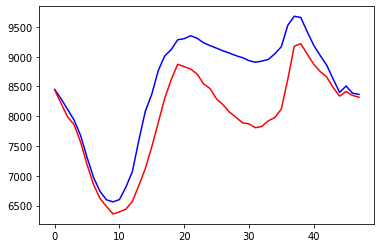

70 -------------------------------
Model: "model_155"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_156 (InputLayer)       [(None, 48, 4)]           0         
_________________________________________________________________
conv1d_310 (Conv1D)          (None, 48, 48)            240       
_________________________________________________________________
conv1d_311 (Conv1D)          (None, 48, 48)            2352      
_________________________________________________________________
lstm_381 (LSTM)              (None, 48, 48)            18624     
_________________________________________________________________
lstm_382 (LSTM)              (None, 48, 64)            28928     
_________________________________________________________________
lstm_383 (LSTM)              (None, 48)                21696     
_________________________________________________________________
dense_155 (Dense)     

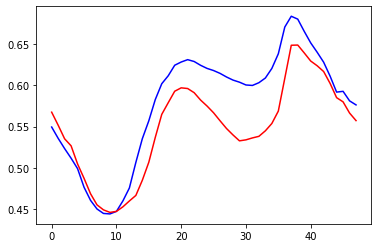

70 -------------------------------
Model: "model_156"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_157 (InputLayer)       [(None, 48, 4)]           0         
_________________________________________________________________
conv1d_312 (Conv1D)          (None, 48, 48)            240       
_________________________________________________________________
conv1d_313 (Conv1D)          (None, 48, 48)            2352      
_________________________________________________________________
lstm_384 (LSTM)              (None, 48, 48)            18624     
_________________________________________________________________
lstm_385 (LSTM)              (None, 48, 64)            28928     
_________________________________________________________________
lstm_386 (LSTM)              (None, 48)                21696     
_________________________________________________________________
dense_156 (Dense)     

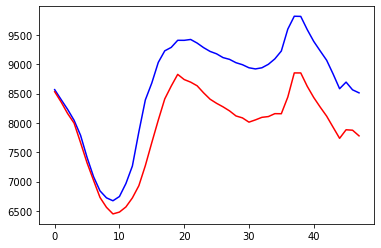

70 -------------------------------
Model: "model_157"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_158 (InputLayer)       [(None, 48, 4)]           0         
_________________________________________________________________
conv1d_314 (Conv1D)          (None, 48, 48)            240       
_________________________________________________________________
conv1d_315 (Conv1D)          (None, 48, 48)            2352      
_________________________________________________________________
lstm_387 (LSTM)              (None, 48, 48)            18624     
_________________________________________________________________
lstm_388 (LSTM)              (None, 48, 64)            28928     
_________________________________________________________________
lstm_389 (LSTM)              (None, 48)                21696     
_________________________________________________________________
dense_157 (Dense)     

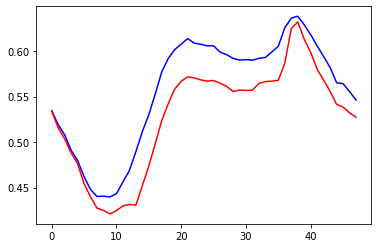

70 -------------------------------
Model: "model_158"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_159 (InputLayer)       [(None, 48, 4)]           0         
_________________________________________________________________
conv1d_316 (Conv1D)          (None, 48, 48)            240       
_________________________________________________________________
conv1d_317 (Conv1D)          (None, 48, 48)            2352      
_________________________________________________________________
lstm_390 (LSTM)              (None, 48, 48)            18624     
_________________________________________________________________
lstm_391 (LSTM)              (None, 48, 64)            28928     
_________________________________________________________________
lstm_392 (LSTM)              (None, 48)                21696     
_________________________________________________________________
dense_158 (Dense)     

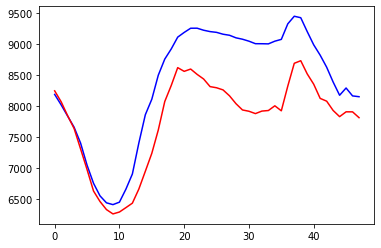

70 -------------------------------
Model: "model_159"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_160 (InputLayer)       [(None, 48, 4)]           0         
_________________________________________________________________
conv1d_318 (Conv1D)          (None, 48, 48)            240       
_________________________________________________________________
conv1d_319 (Conv1D)          (None, 48, 48)            2352      
_________________________________________________________________
lstm_393 (LSTM)              (None, 48, 48)            18624     
_________________________________________________________________
lstm_394 (LSTM)              (None, 48, 64)            28928     
_________________________________________________________________
lstm_395 (LSTM)              (None, 48)                21696     
_________________________________________________________________
dense_159 (Dense)     

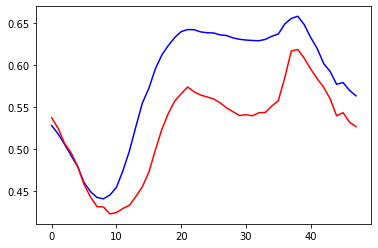

70 -------------------------------
Model: "model_160"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_161 (InputLayer)       [(None, 48, 4)]           0         
_________________________________________________________________
conv1d_320 (Conv1D)          (None, 48, 48)            240       
_________________________________________________________________
conv1d_321 (Conv1D)          (None, 48, 48)            2352      
_________________________________________________________________
lstm_396 (LSTM)              (None, 48, 48)            18624     
_________________________________________________________________
lstm_397 (LSTM)              (None, 48, 64)            28928     
_________________________________________________________________
lstm_398 (LSTM)              (None, 48)                21696     
_________________________________________________________________
dense_160 (Dense)     

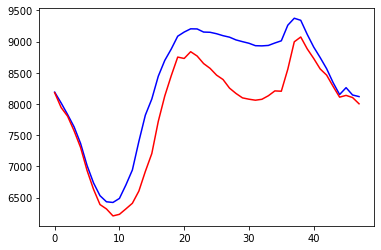

70 -------------------------------
Model: "model_161"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_162 (InputLayer)       [(None, 48, 4)]           0         
_________________________________________________________________
conv1d_322 (Conv1D)          (None, 48, 48)            240       
_________________________________________________________________
conv1d_323 (Conv1D)          (None, 48, 48)            2352      
_________________________________________________________________
lstm_399 (LSTM)              (None, 48, 48)            18624     
_________________________________________________________________
lstm_400 (LSTM)              (None, 48, 64)            28928     
_________________________________________________________________
lstm_401 (LSTM)              (None, 48)                21696     
_________________________________________________________________
dense_161 (Dense)     

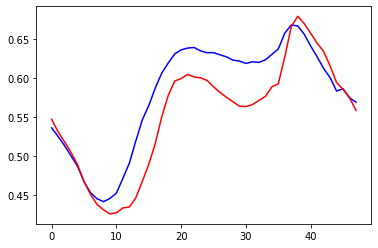

70 -------------------------------
Model: "model_162"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_163 (InputLayer)       [(None, 48, 4)]           0         
_________________________________________________________________
conv1d_324 (Conv1D)          (None, 48, 48)            240       
_________________________________________________________________
conv1d_325 (Conv1D)          (None, 48, 48)            2352      
_________________________________________________________________
lstm_402 (LSTM)              (None, 48, 48)            18624     
_________________________________________________________________
lstm_403 (LSTM)              (None, 48, 64)            28928     
_________________________________________________________________
lstm_404 (LSTM)              (None, 48)                21696     
_________________________________________________________________
dense_162 (Dense)     

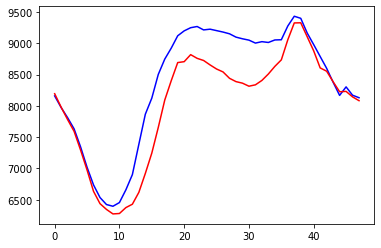

70 -------------------------------
Model: "model_163"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_164 (InputLayer)       [(None, 48, 4)]           0         
_________________________________________________________________
conv1d_326 (Conv1D)          (None, 48, 48)            240       
_________________________________________________________________
conv1d_327 (Conv1D)          (None, 48, 48)            2352      
_________________________________________________________________
lstm_405 (LSTM)              (None, 48, 48)            18624     
_________________________________________________________________
lstm_406 (LSTM)              (None, 48, 64)            28928     
_________________________________________________________________
lstm_407 (LSTM)              (None, 48)                21696     
_________________________________________________________________
dense_163 (Dense)     

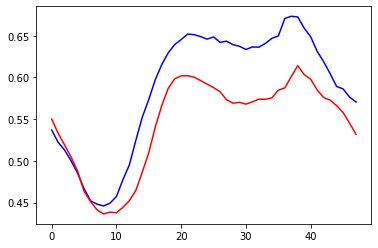

70 -------------------------------
Model: "model_164"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_165 (InputLayer)       [(None, 48, 4)]           0         
_________________________________________________________________
conv1d_328 (Conv1D)          (None, 48, 48)            240       
_________________________________________________________________
conv1d_329 (Conv1D)          (None, 48, 48)            2352      
_________________________________________________________________
lstm_408 (LSTM)              (None, 48, 48)            18624     
_________________________________________________________________
lstm_409 (LSTM)              (None, 48, 64)            28928     
_________________________________________________________________
lstm_410 (LSTM)              (None, 48)                21696     
_________________________________________________________________
dense_164 (Dense)     

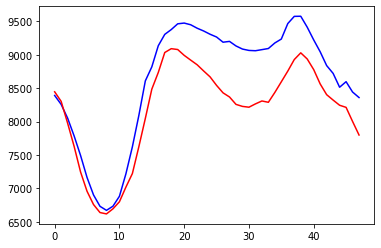

70 -------------------------------
Model: "model_165"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_166 (InputLayer)       [(None, 48, 4)]           0         
_________________________________________________________________
conv1d_330 (Conv1D)          (None, 48, 48)            240       
_________________________________________________________________
conv1d_331 (Conv1D)          (None, 48, 48)            2352      
_________________________________________________________________
lstm_411 (LSTM)              (None, 48, 48)            18624     
_________________________________________________________________
lstm_412 (LSTM)              (None, 48, 64)            28928     
_________________________________________________________________
lstm_413 (LSTM)              (None, 48)                21696     
_________________________________________________________________
dense_165 (Dense)     

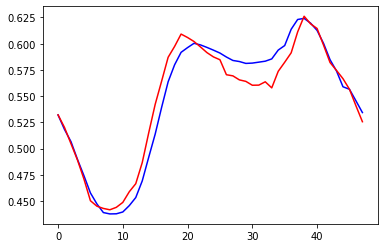

70 -------------------------------
Model: "model_166"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_167 (InputLayer)       [(None, 48, 4)]           0         
_________________________________________________________________
conv1d_332 (Conv1D)          (None, 48, 48)            240       
_________________________________________________________________
conv1d_333 (Conv1D)          (None, 48, 48)            2352      
_________________________________________________________________
lstm_414 (LSTM)              (None, 48, 48)            18624     
_________________________________________________________________
lstm_415 (LSTM)              (None, 48, 64)            28928     
_________________________________________________________________
lstm_416 (LSTM)              (None, 48)                21696     
_________________________________________________________________
dense_166 (Dense)     

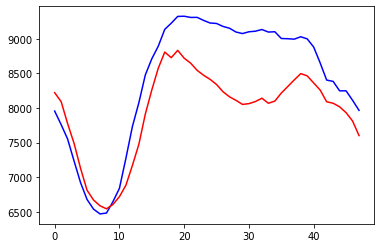

70 -------------------------------
Model: "model_167"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_168 (InputLayer)       [(None, 48, 4)]           0         
_________________________________________________________________
conv1d_334 (Conv1D)          (None, 48, 48)            240       
_________________________________________________________________
conv1d_335 (Conv1D)          (None, 48, 48)            2352      
_________________________________________________________________
lstm_417 (LSTM)              (None, 48, 48)            18624     
_________________________________________________________________
lstm_418 (LSTM)              (None, 48, 64)            28928     
_________________________________________________________________
lstm_419 (LSTM)              (None, 48)                21696     
_________________________________________________________________
dense_167 (Dense)     

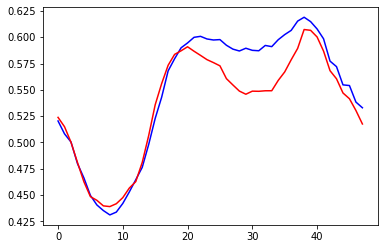

70 -------------------------------
Model: "model_168"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_169 (InputLayer)       [(None, 48, 4)]           0         
_________________________________________________________________
conv1d_336 (Conv1D)          (None, 48, 48)            240       
_________________________________________________________________
conv1d_337 (Conv1D)          (None, 48, 48)            2352      
_________________________________________________________________
lstm_420 (LSTM)              (None, 48, 48)            18624     
_________________________________________________________________
lstm_421 (LSTM)              (None, 48, 64)            28928     
_________________________________________________________________
lstm_422 (LSTM)              (None, 48)                21696     
_________________________________________________________________
dense_168 (Dense)     

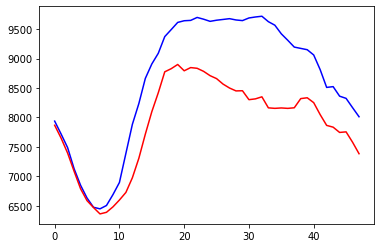

70 -------------------------------
Model: "model_169"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_170 (InputLayer)       [(None, 48, 4)]           0         
_________________________________________________________________
conv1d_338 (Conv1D)          (None, 48, 48)            240       
_________________________________________________________________
conv1d_339 (Conv1D)          (None, 48, 48)            2352      
_________________________________________________________________
lstm_423 (LSTM)              (None, 48, 48)            18624     
_________________________________________________________________
lstm_424 (LSTM)              (None, 48, 64)            28928     
_________________________________________________________________
lstm_425 (LSTM)              (None, 48)                21696     
_________________________________________________________________
dense_169 (Dense)     

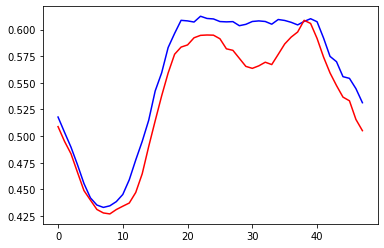

70 -------------------------------
Model: "model_170"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_171 (InputLayer)       [(None, 48, 4)]           0         
_________________________________________________________________
conv1d_340 (Conv1D)          (None, 48, 48)            240       
_________________________________________________________________
conv1d_341 (Conv1D)          (None, 48, 48)            2352      
_________________________________________________________________
lstm_426 (LSTM)              (None, 48, 48)            18624     
_________________________________________________________________
lstm_427 (LSTM)              (None, 48, 64)            28928     
_________________________________________________________________
lstm_428 (LSTM)              (None, 48)                21696     
_________________________________________________________________
dense_170 (Dense)     

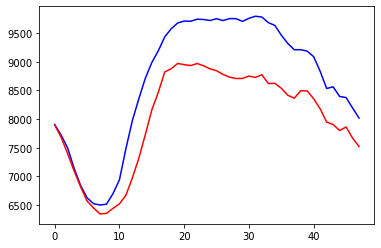

70 -------------------------------
Model: "model_171"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_172 (InputLayer)       [(None, 48, 4)]           0         
_________________________________________________________________
conv1d_342 (Conv1D)          (None, 48, 48)            240       
_________________________________________________________________
conv1d_343 (Conv1D)          (None, 48, 48)            2352      
_________________________________________________________________
lstm_429 (LSTM)              (None, 48, 48)            18624     
_________________________________________________________________
lstm_430 (LSTM)              (None, 48, 64)            28928     
_________________________________________________________________
lstm_431 (LSTM)              (None, 48)                21696     
_________________________________________________________________
dense_171 (Dense)     

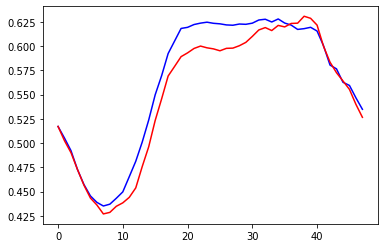

70 -------------------------------
Model: "model_172"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_173 (InputLayer)       [(None, 48, 4)]           0         
_________________________________________________________________
conv1d_344 (Conv1D)          (None, 48, 48)            240       
_________________________________________________________________
conv1d_345 (Conv1D)          (None, 48, 48)            2352      
_________________________________________________________________
lstm_432 (LSTM)              (None, 48, 48)            18624     
_________________________________________________________________
lstm_433 (LSTM)              (None, 48, 64)            28928     
_________________________________________________________________
lstm_434 (LSTM)              (None, 48)                21696     
_________________________________________________________________
dense_172 (Dense)     

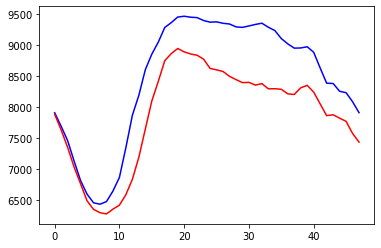

70 -------------------------------
Model: "model_173"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_174 (InputLayer)       [(None, 48, 4)]           0         
_________________________________________________________________
conv1d_346 (Conv1D)          (None, 48, 48)            240       
_________________________________________________________________
conv1d_347 (Conv1D)          (None, 48, 48)            2352      
_________________________________________________________________
lstm_435 (LSTM)              (None, 48, 48)            18624     
_________________________________________________________________
lstm_436 (LSTM)              (None, 48, 64)            28928     
_________________________________________________________________
lstm_437 (LSTM)              (None, 48)                21696     
_________________________________________________________________
dense_173 (Dense)     

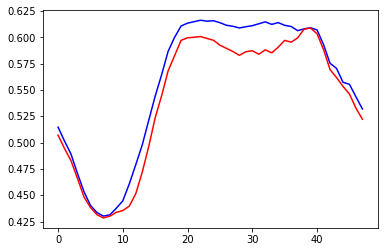

70 -------------------------------
Model: "model_174"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_175 (InputLayer)       [(None, 48, 4)]           0         
_________________________________________________________________
conv1d_348 (Conv1D)          (None, 48, 48)            240       
_________________________________________________________________
conv1d_349 (Conv1D)          (None, 48, 48)            2352      
_________________________________________________________________
lstm_438 (LSTM)              (None, 48, 48)            18624     
_________________________________________________________________
lstm_439 (LSTM)              (None, 48, 64)            28928     
_________________________________________________________________
lstm_440 (LSTM)              (None, 48)                21696     
_________________________________________________________________
dense_174 (Dense)     

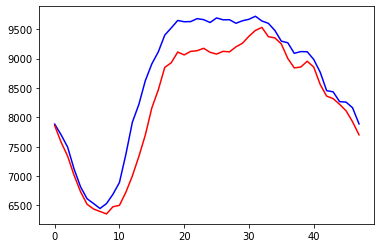

70 -------------------------------
Model: "model_175"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_176 (InputLayer)       [(None, 48, 4)]           0         
_________________________________________________________________
conv1d_350 (Conv1D)          (None, 48, 48)            240       
_________________________________________________________________
conv1d_351 (Conv1D)          (None, 48, 48)            2352      
_________________________________________________________________
lstm_441 (LSTM)              (None, 48, 48)            18624     
_________________________________________________________________
lstm_442 (LSTM)              (None, 48, 64)            28928     
_________________________________________________________________
lstm_443 (LSTM)              (None, 48)                21696     
_________________________________________________________________
dense_175 (Dense)     

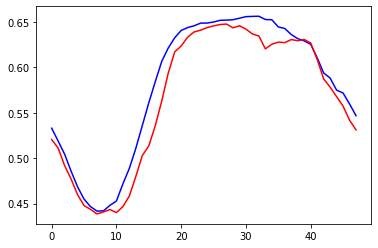

70 -------------------------------
Model: "model_176"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_177 (InputLayer)       [(None, 48, 4)]           0         
_________________________________________________________________
conv1d_352 (Conv1D)          (None, 48, 48)            240       
_________________________________________________________________
conv1d_353 (Conv1D)          (None, 48, 48)            2352      
_________________________________________________________________
lstm_444 (LSTM)              (None, 48, 48)            18624     
_________________________________________________________________
lstm_445 (LSTM)              (None, 48, 64)            28928     
_________________________________________________________________
lstm_446 (LSTM)              (None, 48)                21696     
_________________________________________________________________
dense_176 (Dense)     

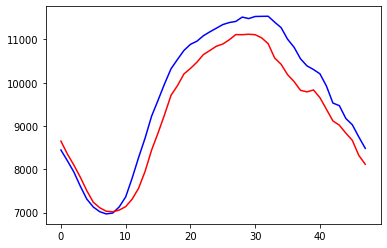

70 -------------------------------
Model: "model_177"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_178 (InputLayer)       [(None, 48, 4)]           0         
_________________________________________________________________
conv1d_354 (Conv1D)          (None, 48, 48)            240       
_________________________________________________________________
conv1d_355 (Conv1D)          (None, 48, 48)            2352      
_________________________________________________________________
lstm_447 (LSTM)              (None, 48, 48)            18624     
_________________________________________________________________
lstm_448 (LSTM)              (None, 48, 64)            28928     
_________________________________________________________________
lstm_449 (LSTM)              (None, 48)                21696     
_________________________________________________________________
dense_177 (Dense)     

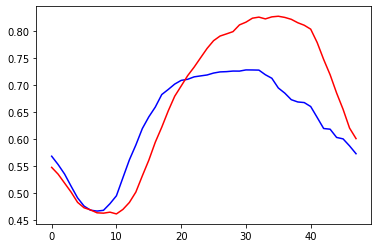

70 -------------------------------
Model: "model_178"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_179 (InputLayer)       [(None, 48, 4)]           0         
_________________________________________________________________
conv1d_356 (Conv1D)          (None, 48, 48)            240       
_________________________________________________________________
conv1d_357 (Conv1D)          (None, 48, 48)            2352      
_________________________________________________________________
lstm_450 (LSTM)              (None, 48, 48)            18624     
_________________________________________________________________
lstm_451 (LSTM)              (None, 48, 64)            28928     
_________________________________________________________________
lstm_452 (LSTM)              (None, 48)                21696     
_________________________________________________________________
dense_178 (Dense)     

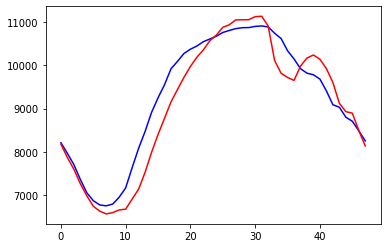

70 -------------------------------
Model: "model_179"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_180 (InputLayer)       [(None, 48, 4)]           0         
_________________________________________________________________
conv1d_358 (Conv1D)          (None, 48, 48)            240       
_________________________________________________________________
conv1d_359 (Conv1D)          (None, 48, 48)            2352      
_________________________________________________________________
lstm_453 (LSTM)              (None, 48, 48)            18624     
_________________________________________________________________
lstm_454 (LSTM)              (None, 48, 64)            28928     
_________________________________________________________________
lstm_455 (LSTM)              (None, 48)                21696     
_________________________________________________________________
dense_179 (Dense)     

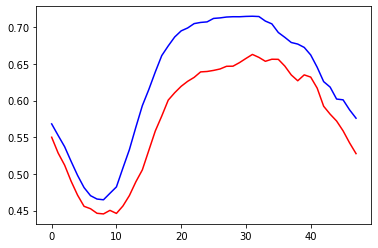

70 -------------------------------
Model: "model_180"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_181 (InputLayer)       [(None, 48, 4)]           0         
_________________________________________________________________
conv1d_360 (Conv1D)          (None, 48, 48)            240       
_________________________________________________________________
conv1d_361 (Conv1D)          (None, 48, 48)            2352      
_________________________________________________________________
lstm_456 (LSTM)              (None, 48, 48)            18624     
_________________________________________________________________
lstm_457 (LSTM)              (None, 48, 64)            28928     
_________________________________________________________________
lstm_458 (LSTM)              (None, 48)                21696     
_________________________________________________________________
dense_180 (Dense)     

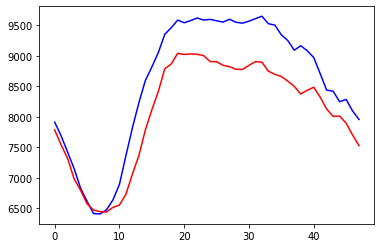

70 -------------------------------
Model: "model_181"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_182 (InputLayer)       [(None, 48, 4)]           0         
_________________________________________________________________
conv1d_362 (Conv1D)          (None, 48, 48)            240       
_________________________________________________________________
conv1d_363 (Conv1D)          (None, 48, 48)            2352      
_________________________________________________________________
lstm_459 (LSTM)              (None, 48, 48)            18624     
_________________________________________________________________
lstm_460 (LSTM)              (None, 48, 64)            28928     
_________________________________________________________________
lstm_461 (LSTM)              (None, 48)                21696     
_________________________________________________________________
dense_181 (Dense)     

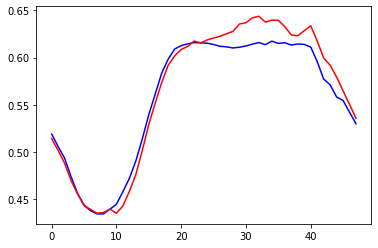

70 -------------------------------
Model: "model_182"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_183 (InputLayer)       [(None, 48, 4)]           0         
_________________________________________________________________
conv1d_364 (Conv1D)          (None, 48, 48)            240       
_________________________________________________________________
conv1d_365 (Conv1D)          (None, 48, 48)            2352      
_________________________________________________________________
lstm_462 (LSTM)              (None, 48, 48)            18624     
_________________________________________________________________
lstm_463 (LSTM)              (None, 48, 64)            28928     
_________________________________________________________________
lstm_464 (LSTM)              (None, 48)                21696     
_________________________________________________________________
dense_182 (Dense)     

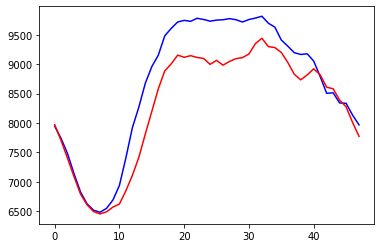

70 -------------------------------
Model: "model_183"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_184 (InputLayer)       [(None, 48, 4)]           0         
_________________________________________________________________
conv1d_366 (Conv1D)          (None, 48, 48)            240       
_________________________________________________________________
conv1d_367 (Conv1D)          (None, 48, 48)            2352      
_________________________________________________________________
lstm_465 (LSTM)              (None, 48, 48)            18624     
_________________________________________________________________
lstm_466 (LSTM)              (None, 48, 64)            28928     
_________________________________________________________________
lstm_467 (LSTM)              (None, 48)                21696     
_________________________________________________________________
dense_183 (Dense)     

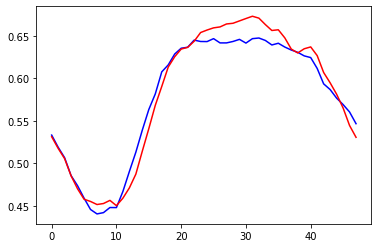

70 -------------------------------
Model: "model_184"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_185 (InputLayer)       [(None, 48, 4)]           0         
_________________________________________________________________
conv1d_368 (Conv1D)          (None, 48, 48)            240       
_________________________________________________________________
conv1d_369 (Conv1D)          (None, 48, 48)            2352      
_________________________________________________________________
lstm_468 (LSTM)              (None, 48, 48)            18624     
_________________________________________________________________
lstm_469 (LSTM)              (None, 48, 64)            28928     
_________________________________________________________________
lstm_470 (LSTM)              (None, 48)                21696     
_________________________________________________________________
dense_184 (Dense)     

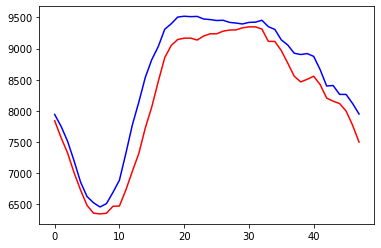

70 -------------------------------
Model: "model_185"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_186 (InputLayer)       [(None, 48, 4)]           0         
_________________________________________________________________
conv1d_370 (Conv1D)          (None, 48, 48)            240       
_________________________________________________________________
conv1d_371 (Conv1D)          (None, 48, 48)            2352      
_________________________________________________________________
lstm_471 (LSTM)              (None, 48, 48)            18624     
_________________________________________________________________
lstm_472 (LSTM)              (None, 48, 64)            28928     
_________________________________________________________________
lstm_473 (LSTM)              (None, 48)                21696     
_________________________________________________________________
dense_185 (Dense)     

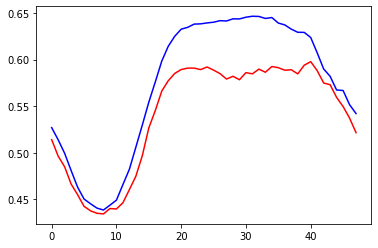

70 -------------------------------
Model: "model_186"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_187 (InputLayer)       [(None, 48, 4)]           0         
_________________________________________________________________
conv1d_372 (Conv1D)          (None, 48, 48)            240       
_________________________________________________________________
conv1d_373 (Conv1D)          (None, 48, 48)            2352      
_________________________________________________________________
lstm_474 (LSTM)              (None, 48, 48)            18624     
_________________________________________________________________
lstm_475 (LSTM)              (None, 48, 64)            28928     
_________________________________________________________________
lstm_476 (LSTM)              (None, 48)                21696     
_________________________________________________________________
dense_186 (Dense)     

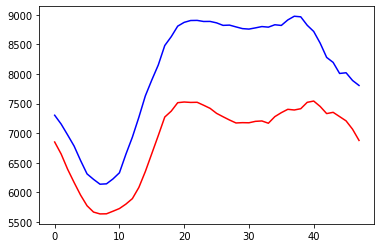

70 -------------------------------
Model: "model_187"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_188 (InputLayer)       [(None, 48, 4)]           0         
_________________________________________________________________
conv1d_374 (Conv1D)          (None, 48, 48)            240       
_________________________________________________________________
conv1d_375 (Conv1D)          (None, 48, 48)            2352      
_________________________________________________________________
lstm_477 (LSTM)              (None, 48, 48)            18624     
_________________________________________________________________
lstm_478 (LSTM)              (None, 48, 64)            28928     
_________________________________________________________________
lstm_479 (LSTM)              (None, 48)                21696     
_________________________________________________________________
dense_187 (Dense)     

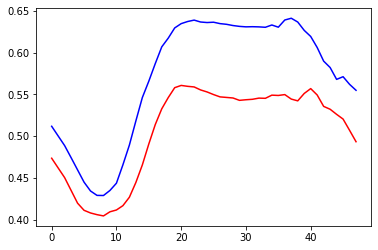

70 -------------------------------
Model: "model_188"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_189 (InputLayer)       [(None, 48, 4)]           0         
_________________________________________________________________
conv1d_376 (Conv1D)          (None, 48, 48)            240       
_________________________________________________________________
conv1d_377 (Conv1D)          (None, 48, 48)            2352      
_________________________________________________________________
lstm_480 (LSTM)              (None, 48, 48)            18624     
_________________________________________________________________
lstm_481 (LSTM)              (None, 48, 64)            28928     
_________________________________________________________________
lstm_482 (LSTM)              (None, 48)                21696     
_________________________________________________________________
dense_188 (Dense)     

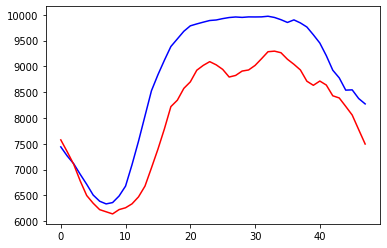

70 -------------------------------
Model: "model_189"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_190 (InputLayer)       [(None, 48, 4)]           0         
_________________________________________________________________
conv1d_378 (Conv1D)          (None, 48, 48)            240       
_________________________________________________________________
conv1d_379 (Conv1D)          (None, 48, 48)            2352      
_________________________________________________________________
lstm_483 (LSTM)              (None, 48, 48)            18624     
_________________________________________________________________
lstm_484 (LSTM)              (None, 48, 64)            28928     
_________________________________________________________________
lstm_485 (LSTM)              (None, 48)                21696     
_________________________________________________________________
dense_189 (Dense)     

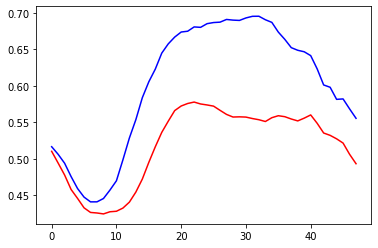

70 -------------------------------
Model: "model_190"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_191 (InputLayer)       [(None, 48, 4)]           0         
_________________________________________________________________
conv1d_380 (Conv1D)          (None, 48, 48)            240       
_________________________________________________________________
conv1d_381 (Conv1D)          (None, 48, 48)            2352      
_________________________________________________________________
lstm_486 (LSTM)              (None, 48, 48)            18624     
_________________________________________________________________
lstm_487 (LSTM)              (None, 48, 64)            28928     
_________________________________________________________________
lstm_488 (LSTM)              (None, 48)                21696     
_________________________________________________________________
dense_190 (Dense)     

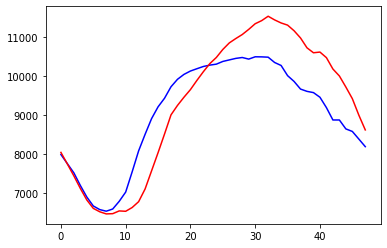

70 -------------------------------
Model: "model_191"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_192 (InputLayer)       [(None, 48, 4)]           0         
_________________________________________________________________
conv1d_382 (Conv1D)          (None, 48, 48)            240       
_________________________________________________________________
conv1d_383 (Conv1D)          (None, 48, 48)            2352      
_________________________________________________________________
lstm_489 (LSTM)              (None, 48, 48)            18624     
_________________________________________________________________
lstm_490 (LSTM)              (None, 48, 64)            28928     
_________________________________________________________________
lstm_491 (LSTM)              (None, 48)                21696     
_________________________________________________________________
dense_191 (Dense)     

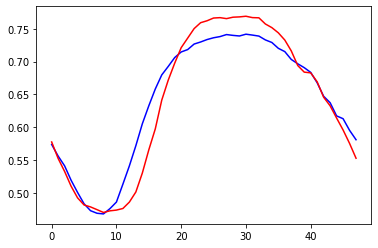

70 -------------------------------
Model: "model_192"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_193 (InputLayer)       [(None, 48, 4)]           0         
_________________________________________________________________
conv1d_384 (Conv1D)          (None, 48, 48)            240       
_________________________________________________________________
conv1d_385 (Conv1D)          (None, 48, 48)            2352      
_________________________________________________________________
lstm_492 (LSTM)              (None, 48, 48)            18624     
_________________________________________________________________
lstm_493 (LSTM)              (None, 48, 64)            28928     
_________________________________________________________________
lstm_494 (LSTM)              (None, 48)                21696     
_________________________________________________________________
dense_192 (Dense)     

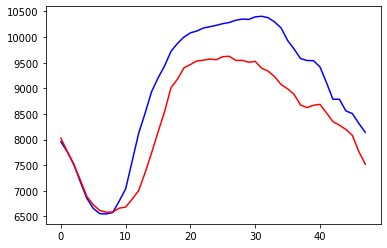

70 -------------------------------
Model: "model_193"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_194 (InputLayer)       [(None, 48, 4)]           0         
_________________________________________________________________
conv1d_386 (Conv1D)          (None, 48, 48)            240       
_________________________________________________________________
conv1d_387 (Conv1D)          (None, 48, 48)            2352      
_________________________________________________________________
lstm_495 (LSTM)              (None, 48, 48)            18624     
_________________________________________________________________
lstm_496 (LSTM)              (None, 48, 64)            28928     
_________________________________________________________________
lstm_497 (LSTM)              (None, 48)                21696     
_________________________________________________________________
dense_193 (Dense)     

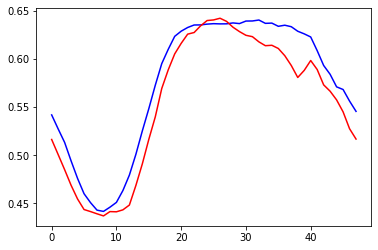

70 -------------------------------
Model: "model_194"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_195 (InputLayer)       [(None, 48, 4)]           0         
_________________________________________________________________
conv1d_388 (Conv1D)          (None, 48, 48)            240       
_________________________________________________________________
conv1d_389 (Conv1D)          (None, 48, 48)            2352      
_________________________________________________________________
lstm_498 (LSTM)              (None, 48, 48)            18624     
_________________________________________________________________
lstm_499 (LSTM)              (None, 48, 64)            28928     
_________________________________________________________________
lstm_500 (LSTM)              (None, 48)                21696     
_________________________________________________________________
dense_194 (Dense)     

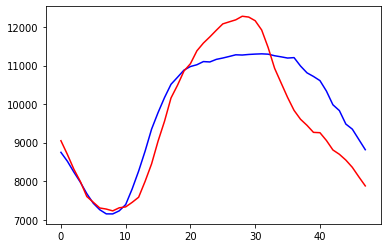

70 -------------------------------
Model: "model_195"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_196 (InputLayer)       [(None, 48, 4)]           0         
_________________________________________________________________
conv1d_390 (Conv1D)          (None, 48, 48)            240       
_________________________________________________________________
conv1d_391 (Conv1D)          (None, 48, 48)            2352      
_________________________________________________________________
lstm_501 (LSTM)              (None, 48, 48)            18624     
_________________________________________________________________
lstm_502 (LSTM)              (None, 48, 64)            28928     
_________________________________________________________________
lstm_503 (LSTM)              (None, 48)                21696     
_________________________________________________________________
dense_195 (Dense)     

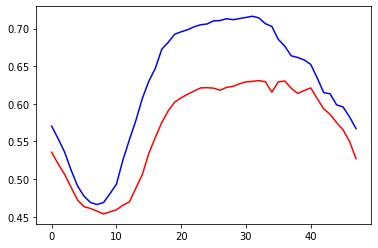

70 -------------------------------
Model: "model_196"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_197 (InputLayer)       [(None, 48, 4)]           0         
_________________________________________________________________
conv1d_392 (Conv1D)          (None, 48, 48)            240       
_________________________________________________________________
conv1d_393 (Conv1D)          (None, 48, 48)            2352      
_________________________________________________________________
lstm_504 (LSTM)              (None, 48, 48)            18624     
_________________________________________________________________
lstm_505 (LSTM)              (None, 48, 64)            28928     
_________________________________________________________________
lstm_506 (LSTM)              (None, 48)                21696     
_________________________________________________________________
dense_196 (Dense)     

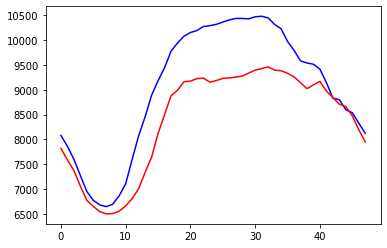

70 -------------------------------
Model: "model_197"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_198 (InputLayer)       [(None, 48, 4)]           0         
_________________________________________________________________
conv1d_394 (Conv1D)          (None, 48, 48)            240       
_________________________________________________________________
conv1d_395 (Conv1D)          (None, 48, 48)            2352      
_________________________________________________________________
lstm_507 (LSTM)              (None, 48, 48)            18624     
_________________________________________________________________
lstm_508 (LSTM)              (None, 48, 64)            28928     
_________________________________________________________________
lstm_509 (LSTM)              (None, 48)                21696     
_________________________________________________________________
dense_197 (Dense)     

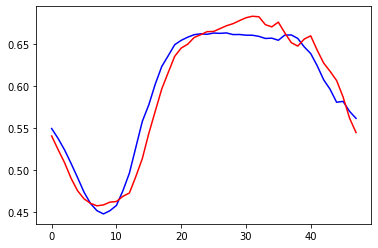

70 -------------------------------
Model: "model_198"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_199 (InputLayer)       [(None, 48, 4)]           0         
_________________________________________________________________
conv1d_396 (Conv1D)          (None, 48, 48)            240       
_________________________________________________________________
conv1d_397 (Conv1D)          (None, 48, 48)            2352      
_________________________________________________________________
lstm_510 (LSTM)              (None, 48, 48)            18624     
_________________________________________________________________
lstm_511 (LSTM)              (None, 48, 64)            28928     
_________________________________________________________________
lstm_512 (LSTM)              (None, 48)                21696     
_________________________________________________________________
dense_198 (Dense)     

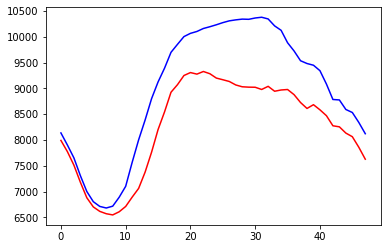

70 -------------------------------
Model: "model_199"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_200 (InputLayer)       [(None, 48, 4)]           0         
_________________________________________________________________
conv1d_398 (Conv1D)          (None, 48, 48)            240       
_________________________________________________________________
conv1d_399 (Conv1D)          (None, 48, 48)            2352      
_________________________________________________________________
lstm_513 (LSTM)              (None, 48, 48)            18624     
_________________________________________________________________
lstm_514 (LSTM)              (None, 48, 64)            28928     
_________________________________________________________________
lstm_515 (LSTM)              (None, 48)                21696     
_________________________________________________________________
dense_199 (Dense)     

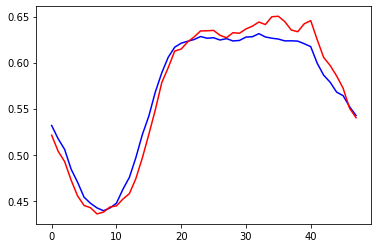

70 -------------------------------
Model: "model_200"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_201 (InputLayer)       [(None, 48, 4)]           0         
_________________________________________________________________
conv1d_400 (Conv1D)          (None, 48, 48)            240       
_________________________________________________________________
conv1d_401 (Conv1D)          (None, 48, 48)            2352      
_________________________________________________________________
lstm_516 (LSTM)              (None, 48, 48)            18624     
_________________________________________________________________
lstm_517 (LSTM)              (None, 48, 64)            28928     
_________________________________________________________________
lstm_518 (LSTM)              (None, 48)                21696     
_________________________________________________________________
dense_200 (Dense)     

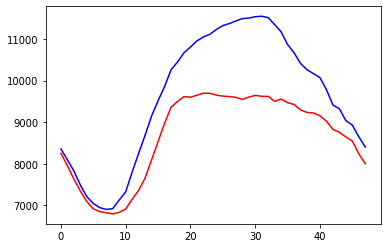

70 -------------------------------
Model: "model_201"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_202 (InputLayer)       [(None, 48, 4)]           0         
_________________________________________________________________
conv1d_402 (Conv1D)          (None, 48, 48)            240       
_________________________________________________________________
conv1d_403 (Conv1D)          (None, 48, 48)            2352      
_________________________________________________________________
lstm_519 (LSTM)              (None, 48, 48)            18624     
_________________________________________________________________
lstm_520 (LSTM)              (None, 48, 64)            28928     
_________________________________________________________________
lstm_521 (LSTM)              (None, 48)                21696     
_________________________________________________________________
dense_201 (Dense)     

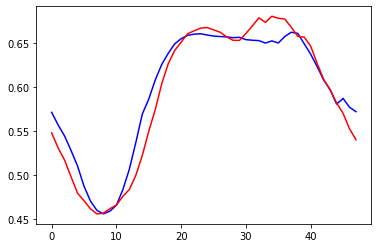

70 -------------------------------
Model: "model_202"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_203 (InputLayer)       [(None, 48, 4)]           0         
_________________________________________________________________
conv1d_404 (Conv1D)          (None, 48, 48)            240       
_________________________________________________________________
conv1d_405 (Conv1D)          (None, 48, 48)            2352      
_________________________________________________________________
lstm_522 (LSTM)              (None, 48, 48)            18624     
_________________________________________________________________
lstm_523 (LSTM)              (None, 48, 64)            28928     
_________________________________________________________________
lstm_524 (LSTM)              (None, 48)                21696     
_________________________________________________________________
dense_202 (Dense)     

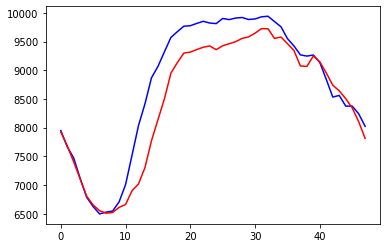

70 -------------------------------
Model: "model_203"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_204 (InputLayer)       [(None, 48, 4)]           0         
_________________________________________________________________
conv1d_406 (Conv1D)          (None, 48, 48)            240       
_________________________________________________________________
conv1d_407 (Conv1D)          (None, 48, 48)            2352      
_________________________________________________________________
lstm_525 (LSTM)              (None, 48, 48)            18624     
_________________________________________________________________
lstm_526 (LSTM)              (None, 48, 64)            28928     
_________________________________________________________________
lstm_527 (LSTM)              (None, 48)                21696     
_________________________________________________________________
dense_203 (Dense)     

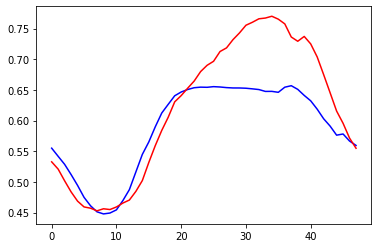

70 -------------------------------
Model: "model_204"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_205 (InputLayer)       [(None, 48, 4)]           0         
_________________________________________________________________
conv1d_408 (Conv1D)          (None, 48, 48)            240       
_________________________________________________________________
conv1d_409 (Conv1D)          (None, 48, 48)            2352      
_________________________________________________________________
lstm_528 (LSTM)              (None, 48, 48)            18624     
_________________________________________________________________
lstm_529 (LSTM)              (None, 48, 64)            28928     
_________________________________________________________________
lstm_530 (LSTM)              (None, 48)                21696     
_________________________________________________________________
dense_204 (Dense)     

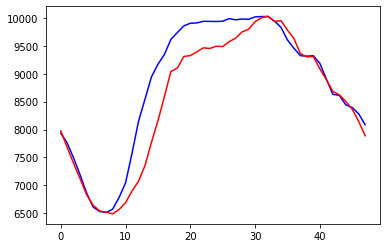

70 -------------------------------
Model: "model_205"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_206 (InputLayer)       [(None, 48, 4)]           0         
_________________________________________________________________
conv1d_410 (Conv1D)          (None, 48, 48)            240       
_________________________________________________________________
conv1d_411 (Conv1D)          (None, 48, 48)            2352      
_________________________________________________________________
lstm_531 (LSTM)              (None, 48, 48)            18624     
_________________________________________________________________
lstm_532 (LSTM)              (None, 48, 64)            28928     
_________________________________________________________________
lstm_533 (LSTM)              (None, 48)                21696     
_________________________________________________________________
dense_205 (Dense)     

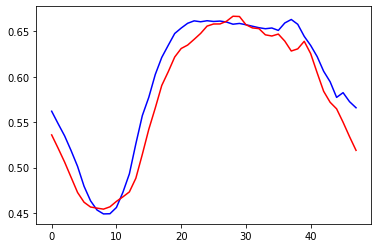

70 -------------------------------
Model: "model_206"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_207 (InputLayer)       [(None, 48, 4)]           0         
_________________________________________________________________
conv1d_412 (Conv1D)          (None, 48, 48)            240       
_________________________________________________________________
conv1d_413 (Conv1D)          (None, 48, 48)            2352      
_________________________________________________________________
lstm_534 (LSTM)              (None, 48, 48)            18624     
_________________________________________________________________
lstm_535 (LSTM)              (None, 48, 64)            28928     
_________________________________________________________________
lstm_536 (LSTM)              (None, 48)                21696     
_________________________________________________________________
dense_206 (Dense)     

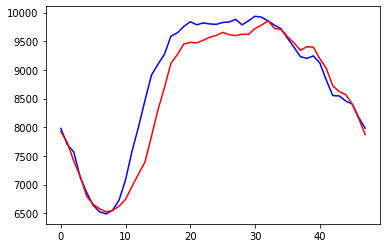

70 -------------------------------
Model: "model_207"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_208 (InputLayer)       [(None, 48, 4)]           0         
_________________________________________________________________
conv1d_414 (Conv1D)          (None, 48, 48)            240       
_________________________________________________________________
conv1d_415 (Conv1D)          (None, 48, 48)            2352      
_________________________________________________________________
lstm_537 (LSTM)              (None, 48, 48)            18624     
_________________________________________________________________
lstm_538 (LSTM)              (None, 48, 64)            28928     
_________________________________________________________________
lstm_539 (LSTM)              (None, 48)                21696     
_________________________________________________________________
dense_207 (Dense)     

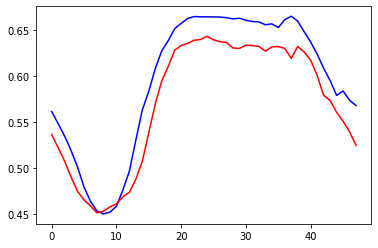

70 -------------------------------
Model: "model_208"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_209 (InputLayer)       [(None, 48, 4)]           0         
_________________________________________________________________
conv1d_416 (Conv1D)          (None, 48, 48)            240       
_________________________________________________________________
conv1d_417 (Conv1D)          (None, 48, 48)            2352      
_________________________________________________________________
lstm_540 (LSTM)              (None, 48, 48)            18624     
_________________________________________________________________
lstm_541 (LSTM)              (None, 48, 64)            28928     
_________________________________________________________________
lstm_542 (LSTM)              (None, 48)                21696     
_________________________________________________________________
dense_208 (Dense)     

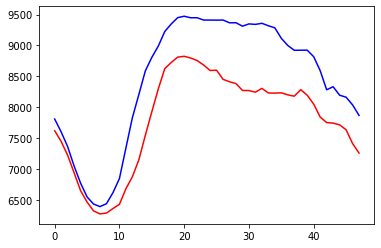

70 -------------------------------
Model: "model_209"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_210 (InputLayer)       [(None, 48, 4)]           0         
_________________________________________________________________
conv1d_418 (Conv1D)          (None, 48, 48)            240       
_________________________________________________________________
conv1d_419 (Conv1D)          (None, 48, 48)            2352      
_________________________________________________________________
lstm_543 (LSTM)              (None, 48, 48)            18624     
_________________________________________________________________
lstm_544 (LSTM)              (None, 48, 64)            28928     
_________________________________________________________________
lstm_545 (LSTM)              (None, 48)                21696     
_________________________________________________________________
dense_209 (Dense)     

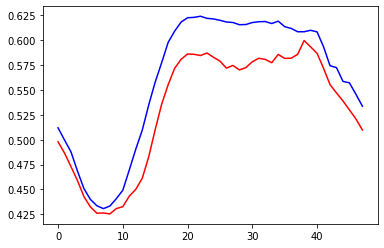

70 -------------------------------
Model: "model_210"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_211 (InputLayer)       [(None, 48, 4)]           0         
_________________________________________________________________
conv1d_420 (Conv1D)          (None, 48, 48)            240       
_________________________________________________________________
conv1d_421 (Conv1D)          (None, 48, 48)            2352      
_________________________________________________________________
lstm_546 (LSTM)              (None, 48, 48)            18624     
_________________________________________________________________
lstm_547 (LSTM)              (None, 48, 64)            28928     
_________________________________________________________________
lstm_548 (LSTM)              (None, 48)                21696     
_________________________________________________________________
dense_210 (Dense)     

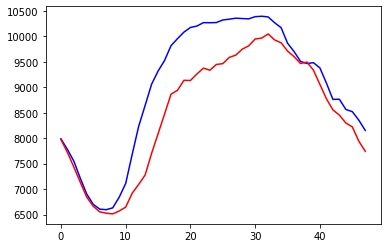

70 -------------------------------
Model: "model_211"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_212 (InputLayer)       [(None, 48, 4)]           0         
_________________________________________________________________
conv1d_422 (Conv1D)          (None, 48, 48)            240       
_________________________________________________________________
conv1d_423 (Conv1D)          (None, 48, 48)            2352      
_________________________________________________________________
lstm_549 (LSTM)              (None, 48, 48)            18624     
_________________________________________________________________
lstm_550 (LSTM)              (None, 48, 64)            28928     
_________________________________________________________________
lstm_551 (LSTM)              (None, 48)                21696     
_________________________________________________________________
dense_211 (Dense)     

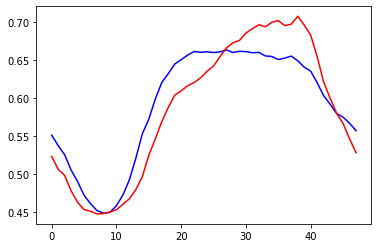

70 -------------------------------
Model: "model_212"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_213 (InputLayer)       [(None, 48, 4)]           0         
_________________________________________________________________
conv1d_424 (Conv1D)          (None, 48, 48)            240       
_________________________________________________________________
conv1d_425 (Conv1D)          (None, 48, 48)            2352      
_________________________________________________________________
lstm_552 (LSTM)              (None, 48, 48)            18624     
_________________________________________________________________
lstm_553 (LSTM)              (None, 48, 64)            28928     
_________________________________________________________________
lstm_554 (LSTM)              (None, 48)                21696     
_________________________________________________________________
dense_212 (Dense)     

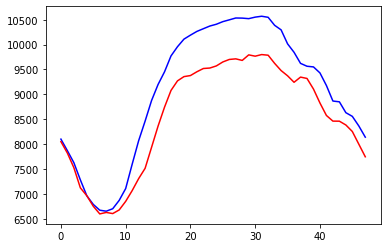

70 -------------------------------
Model: "model_213"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_214 (InputLayer)       [(None, 48, 4)]           0         
_________________________________________________________________
conv1d_426 (Conv1D)          (None, 48, 48)            240       
_________________________________________________________________
conv1d_427 (Conv1D)          (None, 48, 48)            2352      
_________________________________________________________________
lstm_555 (LSTM)              (None, 48, 48)            18624     
_________________________________________________________________
lstm_556 (LSTM)              (None, 48, 64)            28928     
_________________________________________________________________
lstm_557 (LSTM)              (None, 48)                21696     
_________________________________________________________________
dense_213 (Dense)     

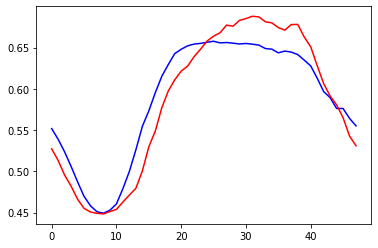

70 -------------------------------
Model: "model_214"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_215 (InputLayer)       [(None, 48, 4)]           0         
_________________________________________________________________
conv1d_428 (Conv1D)          (None, 48, 48)            240       
_________________________________________________________________
conv1d_429 (Conv1D)          (None, 48, 48)            2352      
_________________________________________________________________
lstm_558 (LSTM)              (None, 48, 48)            18624     
_________________________________________________________________
lstm_559 (LSTM)              (None, 48, 64)            28928     
_________________________________________________________________
lstm_560 (LSTM)              (None, 48)                21696     
_________________________________________________________________
dense_214 (Dense)     

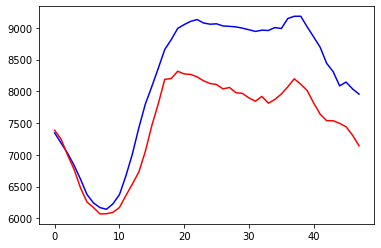

70 -------------------------------
Model: "model_215"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_216 (InputLayer)       [(None, 48, 4)]           0         
_________________________________________________________________
conv1d_430 (Conv1D)          (None, 48, 48)            240       
_________________________________________________________________
conv1d_431 (Conv1D)          (None, 48, 48)            2352      
_________________________________________________________________
lstm_561 (LSTM)              (None, 48, 48)            18624     
_________________________________________________________________
lstm_562 (LSTM)              (None, 48, 64)            28928     
_________________________________________________________________
lstm_563 (LSTM)              (None, 48)                21696     
_________________________________________________________________
dense_215 (Dense)     

In [ ]:
pred_wek = np.array([])
true_wek = np.array([])
for i in weekend_index:
    data = pd.read_csv('datas.csv', index_col=['date'], parse_dates=['date'])
    p, t=mainSet(data, i[0], i[1])
    pred_wek = np.append(pred_wek, p)
    true_wek = np.append(true_wek, t)
    p, t=mainSet(data, i[1], i[2])
    pred_wek = np.append(pred_wek, p)
    true_wek = np.append(true_wek, t)